# E0022_P06_Analysis

Completed by Rebecca Poulos.

In [1]:
source_folder = '/Users/rpoulos/Documents/E0022_Project/E0022_github_source_folder/'

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import scipy.stats
import random
from random import shuffle
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib import gridspec
from matplotlib import mlab
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as PathEffects
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.linear_model import Lasso as lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import nan_euclidean_distances
from Bio import SeqIO
from matplotlib.patches import Patch
from datetime import datetime
import datetime as dt
from sklearn.manifold import MDS
from sklearn import linear_model
import statsmodels as sm
import itertools
from Bio import SeqIO

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='white', font_scale=1)

In [3]:
outline_props = dict(color='black',linewidth=1)

### Import sample mapping

In [4]:
df_sample_map = pd.read_csv('E0022_P06_final_sample_map.txt', sep='\t').set_index('Automatic_MS_filename')
dict_sample_map = df_sample_map.to_dict()
print('Number of MS files in study:',len(df_sample_map))

Number of MS files in study: 7116


In [5]:
df_cell_map = df_sample_map.drop(['Batch','Code','Daisy_chain','Date','Instrument','Replicate'], axis=1).drop_duplicates().set_index('Cell_line')
dict_cell_map = df_cell_map.to_dict()
print('Number of cell lines in study:',len(df_cell_map[lambda x: ~x.index.str.contains('Control_HEK293T')]))

Number of cell lines in study: 979


In [6]:
sidm_dict = df_sample_map[['SIDM','Cell_line']].drop_duplicates().set_index('SIDM').to_dict()['Cell_line']

### Set colours

In [7]:
instrument_colours={
    'M01':'#66c2a5', 
    'M02':'#fc8d62', 
    'M03':'#8da0cb', 
    'M04':'#e78ac3', 
    'M05':'#a6d854', 
    'M06':'#ffd92f'
}

batch_colours={
    'P01':'#7fc97f', 
    'P02':'#beaed4', 
    'P03':'#fdc086', 
    'P04':'#386cb0', 
    'P05':'#f0027f', 
    'P06':'#bf5b17'
}

hek_colours = {
    'Control_HEK293T_lys': '#d8b365',
    'Control_HEK293T_std_H002': '#5ab4ac',
    'Control_HEK293T_std_H003': '#addad6'
}

instrument_patch = []
for instrument in instrument_colours:
    instrument_patch.append(Patch(facecolor=instrument_colours[instrument], edgecolor='black', label=''))

In [8]:
colour_list = pd.read_csv('colour_list.txt',header=None)[0].tolist()

num = 0
cancer_colours = {}
for cancer_type in df_sample_map['Cancer_type'].unique().tolist():
    cancer_colours[cancer_type]= colour_list[num]
    num += 1

num = 0
tissue_colours = {}
for tissue_type in df_sample_map['Tissue_type'].unique().tolist():
    tissue_colours[tissue_type] = colour_list[num]
    num += 1
    
tissue_patch = []
for tissue in tissue_colours:
    tissue_patch.append(Patch(facecolor=tissue_colours[tissue], edgecolor='black', label=''))

In [9]:
instruments = sorted(df_sample_map['Instrument'].unique().tolist())
batches = sorted(df_sample_map['Batch'].unique().tolist())
cell_lines = sorted(df_sample_map['Cell_line'].astype(str).unique().tolist())
cancer_types = sorted(df_sample_map['Cancer_type'].unique().tolist())
tissue_types = sorted(df_sample_map['Tissue_type'].unique().tolist())

In [10]:
df_colours = df_sample_map[['Instrument','Batch','Cancer_type','Tissue_type']]
df_colours.loc[:,'Instrument'] = df_colours.loc[:,'Instrument'].map(instrument_colours)
df_colours.loc[:,'Batch'] = df_colours.loc[:,'Batch'].map(batch_colours)
df_colours.loc[:,'Cancer_type'] = df_colours.loc[:,'Cancer_type'].map(cancer_colours)
df_colours.loc[:,'Tissue_type'] = df_colours.loc[:,'Tissue_type'].map(tissue_colours)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


### Import peptide datasets

##### Import raw peptide matrix

In [11]:
df_pept_raw = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Peptide_Matrix_Raw.tsv.gz', sep='\t').set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose()
print('Number of samples: ',df_pept_raw.shape[0])
print('Number of peptides: ',df_pept_raw.shape[1])
print('Missing values (%): ',format(df_pept_raw.isna().sum().sum()/df_pept_raw.size*100,'.2f'))

Number of samples:  7116
Number of peptides:  36834
Missing values (%):  57.02


##### Import median normalised peptide matrix

In [12]:
df_pept_median = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Peptide_Matrix_Median.tsv.gz', sep='\t').set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose()
print('Number of samples: ',df_pept_median.shape[0])
print('Number of peptides: ',df_pept_median.shape[1])
print('Missing values (%): ',format(df_pept_median.isna().sum().sum()/df_pept_median.size*100,'.2f'))

Number of samples:  7116
Number of peptides:  36834
Missing values (%):  57.02


##### Import peptide matrix after ProNorM

In [13]:
df_pept = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Peptide_Matrix_RUV.tsv.gz', sep='\t').set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose()
print('Number of samples: ',df_pept.shape[0])
print('Number of peptides: ',df_pept.shape[1])
print('Missing values (%): ',format(df_pept.isna().sum().sum()/df_pept.size*100,'.2f'))

Number of samples:  7116
Number of peptides:  36806
Missing values (%):  56.99


In [14]:
df_pept_TR = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Peptide_Matrix_ProNorM.tsv.gz', sep='\t').set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose()
print('Number of samples: ',df_pept_TR.shape[0])
print('Number of peptides: ',df_pept_TR.shape[1])
print('Missing values (%): ',format(df_pept_TR.isna().sum().sum()/df_pept_TR.size*100,'.2f'))

Number of samples:  7116
Number of peptides:  36806
Missing values (%):  42.80


##### Identify peptides to exclude

In [15]:
iRT_peptides = [x for x in df_pept_raw.columns.tolist() if 'RMIS' in x or 'Biognosys' in x]
non_human_peptides = [x for x in df_pept_raw.columns.tolist() if x not in iRT_peptides and '_HUMAN' not in x]
print('Number of iRT peptides:', len(iRT_peptides))
print('Number of non-human peptides:', len(non_human_peptides))
peptides_to_exclude = iRT_peptides+non_human_peptides
proteins_to_exclude = list(set([x.split('=')[0] for x in peptides_to_exclude]))

Number of iRT peptides: 67
Number of non-human peptides: 3


In [16]:
df_pept_raw = df_pept_raw[[x for x in df_pept_raw.columns.tolist() if x not in peptides_to_exclude]]
df_pept_median = df_pept_median[[x for x in df_pept_median.columns.tolist() if x not in peptides_to_exclude]]
df_pept = df_pept[[x for x in df_pept.columns.tolist() if x not in peptides_to_exclude]]
df_pept_TR = df_pept_TR[[x for x in df_pept_TR.columns.tolist() if x not in peptides_to_exclude]]

### Import protein datasets

In [17]:
df_prot_raw = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Protein_Matrix_Raw.tsv.gz', sep='\t').set_index('Cell_line')
df_prot_median = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Protein_Matrix_Median.tsv.gz', sep='\t').set_index('Cell_line')
df_prot = pd.read_csv(source_folder+'final_datasets_080420/datasets_080420/E0022_P06_Protein_Matrix_ProNorM.tsv.gz', sep='\t').set_index('Cell_line')

In [18]:
print('Raw:',df_prot_raw.shape[1],'proteins.')
print('Median:',df_prot_median.shape[1],'proteins.')
print('ProNorM:',df_prot.shape[1],'proteins.')

Raw: 3590 proteins.
Median: 3067 proteins.
ProNorM: 3425 proteins.


In [19]:
df_prot_rep = pd.read_csv(source_folder+'final_datasets_080420/E0022_P06_Protein_Matrix_Replicate_ProNorM.tsv.gz', sep='\t').rename(columns={'Unnamed: 0':'index'}).set_index('index')

### Import RNA-seq data

In [339]:
df_rna = pd.read_csv(source_folder+'rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
rna_gene_list = pd.DataFrame(index=df_rna.index.tolist()).reset_index().to_csv(source_folder+'rna_gene_list.txt', index=False)
gene_protein_dict = pd.read_csv(source_folder+'rna_gene_mapping.tab', sep='\t', header=None).drop(0)
gene_protein_dict = gene_protein_dict[lambda x: x[0].isin(gene_protein_dict.groupby(0).size().to_frame('Val')[lambda x: x.Val == 1].index.tolist())].set_index(0).to_dict()[2]
df_rna.index = df_rna.index.map(gene_protein_dict)
df_rna = df_rna[lambda x: ~x.index.isna()].transpose()
df_rna.index = df_rna.index.map(sidm_dict)
df_rna = df_rna[lambda x: ~x.index.isna()]

In [340]:
gene_to_protein_dict = pd.read_csv(source_folder+'master_protein_to_gene_mapping.txt', sep='\t', header=None).set_index(1).to_dict()[0]
protein_to_gene_dict = pd.read_csv(source_folder+'master_protein_to_gene_mapping.txt', sep='\t', header=None).set_index(0).to_dict()[1]
cancer_genes = pd.read_csv(source_folder+'cancer_genes_latest_28102019.csv')['gene_symbol'].tolist()
cancer_proteins = [gene_to_protein_dict[x] for x in cancer_genes if x in gene_to_protein_dict]
print('Number of cancer-associated proteins:',len(cancer_proteins))

Number of cancer-associated proteins: 126


### Comparison of datasets

##### Protein-wise RNA correlations

In [184]:
def get_rna_protein_correlation_proteinwise(dtaframe):
    rna_corr = pd.DataFrame()
    combined_list = dtaframe.columns.tolist()+df_rna.columns.tolist()
    for protein in [x for x in combined_list if combined_list.count(x) == 2]:
        curr_df = dtaframe[[protein]].rename(columns={protein:'Protein'}).join(df_rna[[protein]]).rename(columns={protein:'RNA'}).dropna()
        if len(curr_df) > 1:
            rna_corr.loc[protein,'Correlation'] = scipy.stats.pearsonr(curr_df['Protein'], curr_df['RNA'])[0]
    return rna_corr

In [185]:
def generate_correlation_plot(dtaframes, labels, title, hist_bool):
    num = 0
    for dtaframe in dtaframes:
        plot = sns.distplot(dtaframe['Correlation'].dropna(), color=colour_list[num], hist=hist_bool, label=labels[num]+' - '+str(format(dtaframe['Correlation'].median(),'.2f'))+'   (n = '+str(len(dtaframe['Correlation'].dropna()))+' proteins)')
        plot.axvline(x=dtaframe['Correlation'].median(), color=colour_list[num], linewidth=2, linestyle='--')
        num += 1
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title(title, fontsize=14, weight='bold')
    plt.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=14)
    plt.show()

In [23]:
rna_corr_prot_raw = get_rna_protein_correlation_proteinwise(df_prot_raw)
rna_corr_prot_median = get_rna_protein_correlation_proteinwise(df_prot_median)
rna_corr_prot = get_rna_protein_correlation_proteinwise(df_prot)

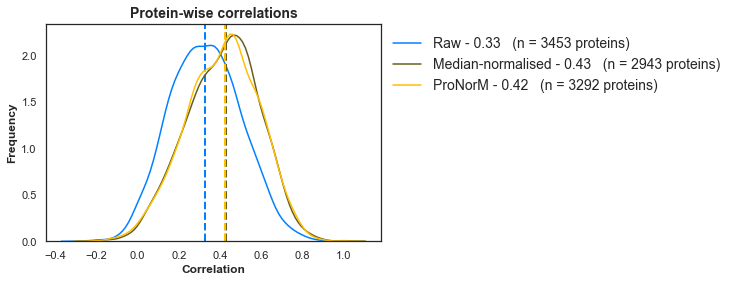

In [24]:
generate_correlation_plot([
    rna_corr_prot_raw,
    rna_corr_prot_median,
    rna_corr_prot], [
    'Raw',
    'Median-normalised',
    'ProNorM'], 
    'Protein-wise correlations', False)

##### Cell line-wise RNA correlations

In [186]:
def get_rna_protein_correlation_cellwise(dtaframe):
    rna_corr = pd.DataFrame()
    combined_list = dtaframe.index.tolist()+df_rna.index.tolist()
    for cell_line in [x for x in combined_list if combined_list.count(x) == 2]:
        curr_df = dtaframe.transpose()[[cell_line]].rename(columns={cell_line:'Protein'}).join(df_rna.transpose()[[cell_line]]).rename(columns={cell_line:'RNA'}).dropna()
        if len(curr_df) > 1:
            rna_corr.loc[cell_line,'Correlation'] = scipy.stats.pearsonr(curr_df['Protein'], curr_df['RNA'])[0]
    return rna_corr

In [187]:
def generate_correlation_plot(dtaframes, labels, title, hist_bool):
    num = 0
    for dtaframe in dtaframes:
        plot = sns.distplot(dtaframe['Correlation'].dropna(), color=colour_list[num], hist=hist_bool, label=labels[num]+' - '+str(format(dtaframe['Correlation'].median(),'.2f'))+'   (n = '+str(len(dtaframe['Correlation'].dropna()))+' proteins)')
        plot.axvline(x=dtaframe['Correlation'].median(), color=colour_list[num], linewidth=2, linestyle='--')
        num += 1
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title(title, fontsize=14, weight='bold')
    plt.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=14)
    plt.show()

In [27]:
rna_corr_cell_raw = get_rna_protein_correlation_cellwise(df_prot_raw)
rna_corr_cell_median = get_rna_protein_correlation_cellwise(df_prot_median)
rna_corr_cell = get_rna_protein_correlation_cellwise(df_prot)

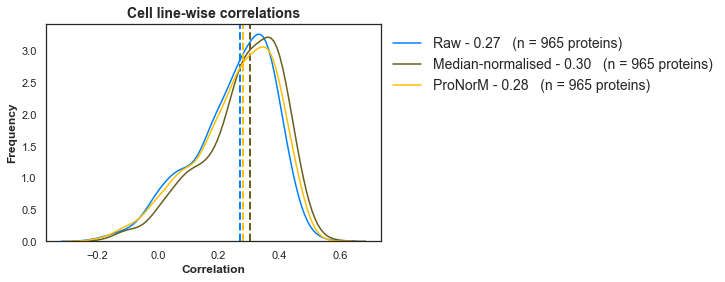

In [28]:
generate_correlation_plot([
    rna_corr_cell_raw,
    rna_corr_cell_median,
    rna_corr_cell], [
    'Raw',
    'Median-normalised',
    'ProNorM'], 
    'Cell line-wise correlations', False)

##### Assessment of protein correlations

In [30]:
def compare_correlations(dtaframe_A, dtaframe_B, title, colour):
    corr_df = pd.DataFrame()
    for protein in [x for x in dtaframe_A.columns.tolist() if x in dtaframe_B.columns.tolist()]:
        curr_df = dtaframe_A[[protein]].rename(columns={protein:'A'}).join(dtaframe_B[[protein]].rename(columns={protein:'B'})).dropna()
        if len(curr_df) > 1:
            corr_df.loc[protein,'Correlation'] = scipy.stats.pearsonr(curr_df['A'], curr_df['B'])[0]
    plot = sns.distplot(corr_df['Correlation'], color=colour, label=title+': '+str(format(corr_df['Correlation'].median(),'.2f')), hist=True)
    plt.legend(frameon=False, fontsize=14, loc='upper left')
    return plot

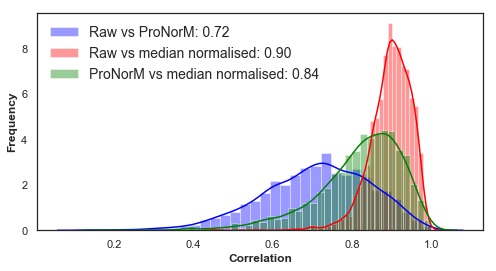

In [31]:
fig = plt.figure(figsize=[8,4])
plot = compare_correlations(df_prot_raw, df_prot, 'Raw vs ProNorM', 'blue')
plot = compare_correlations(df_prot_raw, df_prot_median, 'Raw vs median normalised', 'red')
plot = compare_correlations(df_prot, df_prot_median, 'ProNorM vs median normalised', 'green')
plot.set_xlabel('Correlation', weight='bold')
plot.set_ylabel('Frequency', weight='bold')
plt.show()

### Replicate correlations

In [32]:
def get_correlation_figures(dtaframe, dtatype, items, sample_map):
    df_corr = dtaframe.transpose().corr()
    plot_df = pd.DataFrame()
    for sample in df_corr.index.tolist():
        for item in items:
            plot_df.loc[sample,item] = df_corr.drop(sample).loc[sample_map[lambda x: x[item] == sample_map.loc[sample, item]].index.tolist(),sample].mean()
        plot_df.loc[sample,'All_samples'] = df_corr.drop(sample)[sample].mean()
    plot_df = plot_df.unstack().to_frame('Correlation').reset_index().rename(columns={'level_0':'Item'}).drop('level_1', axis=1)
    plot_df['Dataset'] = dtatype
    return plot_df

##### Peptide level

In [33]:
cell_lines_of_interest = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].tolist()
random.shuffle(cell_lines_of_interest)
samples_of_interest = df_sample_map[lambda x: x.Cell_line.isin(cell_lines_of_interest[0:100])].index.tolist()

df_corr_pept_raw = get_correlation_figures(df_pept_raw[lambda x: x.index.isin(samples_of_interest)], 'Raw', ['Cell_line','Cancer_type','Tissue_type','Batch','Instrument'], df_sample_map)
df_corr_pept_median = get_correlation_figures(df_pept_median[lambda x: x.index.isin(samples_of_interest)], 'Median', ['Cell_line','Cancer_type','Tissue_type','Batch','Instrument'], df_sample_map)
df_corr_pept = get_correlation_figures(df_pept[lambda x: x.index.isin(samples_of_interest)], 'ProNorM', ['Cell_line','Cancer_type','Tissue_type','Batch','Instrument'], df_sample_map)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


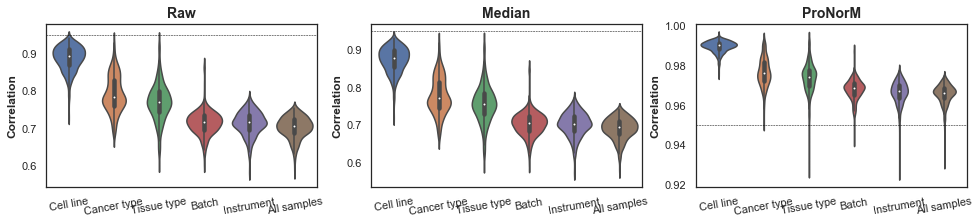

In [34]:
plot_df = pd.concat([df_corr_pept_raw, df_corr_pept_median, df_corr_pept])
fig = plt.figure(figsize=[16.5,3])
num = 0
for dtaset in plot_df['Dataset'].unique().tolist():
    num += 1
    ax = fig.add_subplot(1,3,num)
    plot = sns.violinplot(x='Item', y='Correlation', data=plot_df[lambda x: x.Dataset == dtaset])
    plot.set_title(dtaset, fontsize=14, weight='bold')
    plot.set_xticklabels([x.get_text().replace('_',' ') for x in plot.get_xticklabels()], rotation=10)
    plot.set_xlabel('')
    plot.set_ylabel('Correlation', weight='bold')
    plot.axhline(y=0.95, linestyle='--', linewidth=0.5, color='black')
plt.subplots_adjust(wspace=0.2)
plt.show()

##### Protein level

In [35]:
df_corr_prot_raw = get_correlation_figures(df_prot_raw.loc[df_cell_map[lambda x: ~x.Tissue_type.isin(['Adrenal Gland','Small Intestine','Control_HEK293T'])].index.tolist()], 'Raw', ['Cancer_type','Tissue_type'], df_cell_map)
df_corr_prot_median = get_correlation_figures(df_prot_median.loc[df_cell_map[lambda x: ~x.Tissue_type.isin(['Adrenal Gland','Small Intestine','Control_HEK293T'])].index.tolist()], 'Median', ['Cancer_type','Tissue_type'], df_cell_map)
df_corr_prot = get_correlation_figures(df_prot.loc[df_cell_map[lambda x: ~x.Tissue_type.isin(['Adrenal Gland','Small Intestine','Control_HEK293T'])].index.tolist()], 'ProNorM', ['Cancer_type','Tissue_type'], df_cell_map)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


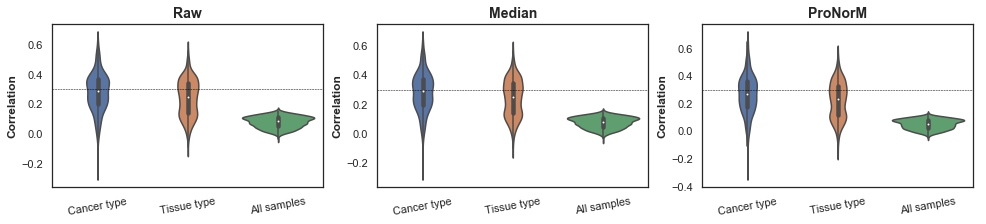

In [36]:
plot_df = pd.concat([df_corr_prot_raw, df_corr_prot_median, df_corr_prot])
fig = plt.figure(figsize=[16.5,3])
num = 0
for dtaset in plot_df['Dataset'].unique().tolist():
    num += 1
    ax = fig.add_subplot(1,3,num)
    plot = sns.violinplot(x='Item', y='Correlation', data=plot_df[lambda x: x.Dataset == dtaset])
    plot.set_title(dtaset, fontsize=14, weight='bold')
    plot.set_xticklabels([x.get_text().replace('_',' ') for x in plot.get_xticklabels()], rotation=10)
    plot.set_xlabel('')
    plot.set_ylabel('Correlation', weight='bold')
    plot.axhline(y=0.3, linestyle='--', linewidth=0.5, color='black')
plt.subplots_adjust(wspace=0.2)
plt.show()

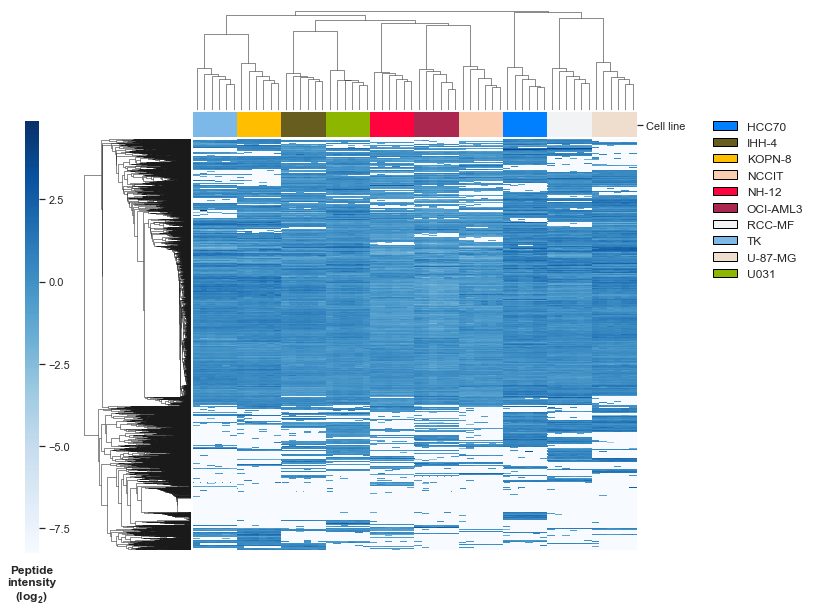

In [268]:
curr_cell_lines = cell_lines.copy()
random.shuffle(curr_cell_lines)
cell_lines_of_interest = sorted(curr_cell_lines[0:10])
curr_df = df_prot_rep.join(df_sample_map['Cell_line'])[lambda x: x.Cell_line.isin(cell_lines_of_interest)].drop('Cell_line', axis=1)
curr_df = curr_df.fillna(curr_df.min().min()).reset_index().rename(columns={'index':''}).set_index('')
curr_df_colours = pd.DataFrame(index=curr_df.index.tolist(),columns=['Cell line'])
num = 0
for cell_line in cell_lines_of_interest:
    curr_df_colours.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist(),'Cell line'] = colour_list[num]
    num +=1
plot = sns.clustermap(curr_df.transpose(), row_cluster=True, col_cluster=True, xticklabels=False, yticklabels=False, cmap=plt.cm.Blues, col_colors=curr_df_colours)
plot.cax.set_position((0.05,0.12,0.02,0.6))
plt.xlabel('\nPeptide\nintensity\n(log'+'$\mathregular{_2}$'+')', weight='bold')
for cell_line in cell_lines_of_interest:
    plot.ax_col_dendrogram.bar(0, 0, color=curr_df_colours.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()[0],'Cell line'], label=cell_line, linewidth=1, edgecolor='black')
plot.ax_col_dendrogram.legend(bbox_to_anchor=(1.4,0), ncol=1, fontsize=12, frameon=False)
plt.show()

### Comparison with transcriptomics

##### Overall protein-wise correlation

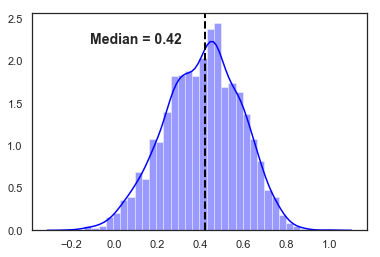

In [293]:
plot = sns.distplot(rna_corr_prot, color='blue')
median = rna_corr_prot['Correlation'].median()
plot.text(0,-0.7, 'Median = '+format(median,'.2f'), transform=ax.transAxes, fontsize=14, weight='bold')
plot.axvline(x=median, linestyle='--', color='black', linewidth=2)
plt.show()

##### Correlation per tissue type

In [312]:
df_corr_tissue = pd.DataFrame()
for tissue_type in tissue_types:
    curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: x.Tissue_type == tissue_type].drop('Tissue_type', axis=1)
    curr_corr = get_rna_protein_correlation_proteinwise(curr_df)
    curr_corr['Tissue_type'] = tissue_type
    df_corr_tissue = pd.concat([df_corr_tissue, curr_corr], sort=True)
corr_tissue_dict = df_corr_tissue.groupby('Tissue_type').median().to_dict()['Correlation']
df_corr_tissue['Median_corr'] = df_corr_tissue['Tissue_type'].map(corr_tissue_dict)
df_corr_tissue = df_corr_tissue.sort_values('Median_corr')

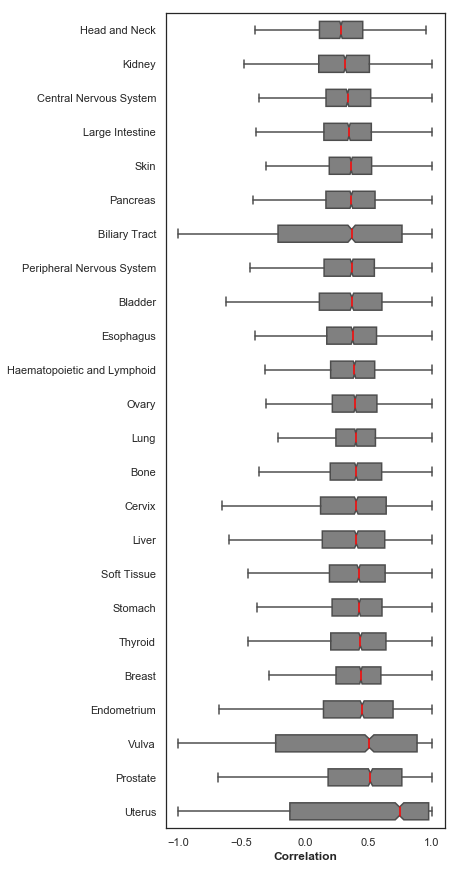

In [329]:
fig = plt.figure(figsize=[5,15])
plot = sns.boxplot(y='Tissue_type', x='Correlation', data=df_corr_tissue, color='grey', dodge=False, showfliers=False, notch=True, width=0.5, medianprops={'color':'red'})
plot.set_xlabel('Correlation', weight='bold')
plot.set_ylabel('')
plt.show()

##### Correlation of cancer driver genes

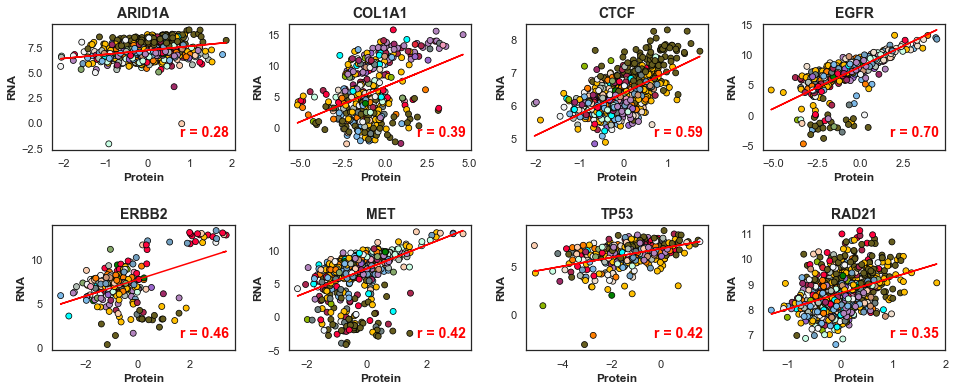

In [221]:
curr_proteins = ['ARI1A_HUMAN','CO1A1_HUMAN','CTCF_HUMAN','EGFR_HUMAN','ERBB2_HUMAN','MET_HUMAN','P53_HUMAN','RAD21_HUMAN']
fig = plt.figure(figsize=[16,6])
num = 0
for protein in curr_proteins:
    num += 1
    curr_df = df_prot[[protein]].rename(columns={protein:'Protein'}).join(df_rna[protein]).rename(columns={protein:'RNA'}).dropna().join(df_cell_map['Tissue_type'])

    X = curr_df.Protein.values.reshape(-1,1)
    y = curr_df.RNA.values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    ax = fig.add_subplot(2,4,num)
    plot = sns.scatterplot(x='Protein', y='RNA', data=curr_df, hue='Tissue_type', palette=tissue_colours, edgecolor='black')# color='blue')
    plot.plot(X, y, color='red')
    plot.set_xlabel('Protein', weight='bold')
    plot.set_ylabel('RNA', weight='bold')
    plot.set_title(protein_to_gene_dict[protein], weight='bold', fontsize=14)
    plot.text(0.7, 0.1, 'r = '+format(scipy.stats.pearsonr(curr_df.Protein, curr_df.RNA)[0],'.2f'), weight='bold', color='red', fontsize=14, transform=ax.transAxes)
    plot.legend_.remove()
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

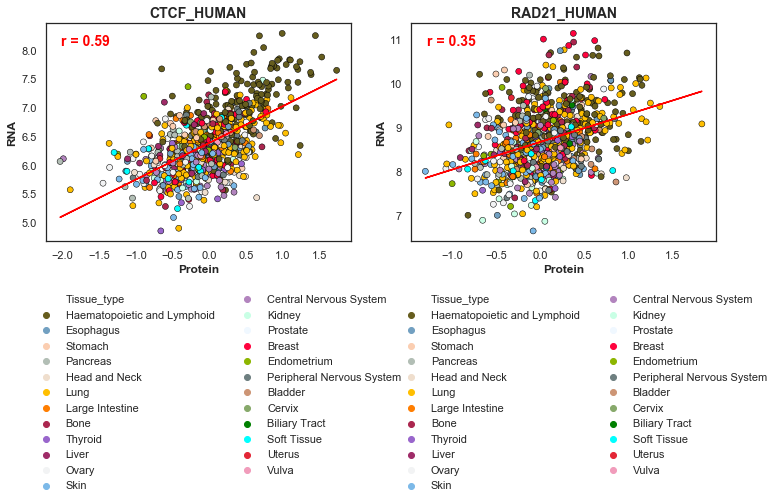

In [1032]:
def make_correlation_plot_indiv(protein):
    curr_df = df_rna[[protein]].rename(columns={protein:'RNA'}).join(df_prot[[protein]].rename(columns={protein:'Protein'})).dropna().join(df_cell_map['Tissue_type'])
    plot = sns.scatterplot(x='Protein', y='RNA', data=curr_df, hue='Tissue_type', palette=tissue_colours, edgecolor='black', linewidth=0.5)
    plot.set_xlabel('Protein', weight='bold')
    plot.set_ylabel('RNA', weight='bold')
    plot.set_title(protein, weight='bold', fontsize=14)
    X = curr_df['Protein'].values.reshape(-1,1)
    y = curr_df['RNA'].values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    plot.plot(X, y, color='red')
    plot.text(0.05,0.9,'r = '+format(scipy.stats.pearsonr(curr_df['Protein'], curr_df['RNA'])[0],'.2f'), fontsize=14, color='red', weight='bold', transform=ax.transAxes)
    plot.legend(bbox_to_anchor=(1.2,-0.2), ncol=2, frameon=False)
    return plot

fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(1,2,1)
make_correlation_plot_indiv('CTCF_HUMAN')
ax = fig.add_subplot(1,2,2)
make_correlation_plot_indiv('RAD21_HUMAN')
plt.show()

##### Integration with copy number

In [499]:
df_cnv = pd.read_csv(source_folder+'copynumber_total_new_map.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_cnv = df_cnv.rename(columns=df_cell_map.reset_index().set_index('SIDM')[['Cell_line']].to_dict()['Cell_line'])
df_cnv = df_cnv[[x for x in df_cnv.columns.tolist() if 'SIDM' not in x]].transpose()
def convert_to_cnv(x):
    if x > 2:
        return '3+'
    elif x == 2:
        return '2'
    elif x == 1:
        return '1'

In [28]:
df_cnv_pval = pd.DataFrame()
for protein in [x for x in df_prot.columns.tolist() if x in protein_to_gene_dict and x in df_rna.columns.tolist()]:
    gene = protein_to_gene_dict[protein]
    if gene in df_cnv.columns.tolist():
        curr_df = df_prot[[protein]].rename(columns={protein:'Protein'}).join(df_cnv[[gene]].rename(columns={gene:'CNV_raw'})).join(df_rna[[protein]].rename(columns={protein:'RNA'})).dropna()
        curr_df['CNV'] = curr_df['CNV_raw'].apply(lambda x: convert_to_cnv(x))
        # Protein
        df_cnv_pval.loc[protein,'prot_pval_amp'] = np.log10(scipy.stats.ttest_ind(curr_df[lambda x: x.CNV == '3+']['Protein'], curr_df[lambda x: x.CNV == '2']['Protein'])[1])*-1
        df_cnv_pval.loc[protein,'prot_pval_del'] = np.log10(scipy.stats.ttest_ind(curr_df[lambda x: x.CNV == '1']['Protein'], curr_df[lambda x: x.CNV == '2']['Protein'])[1])*-1
        df_cnv_pval.loc[protein,'prot_fc_amp'] = curr_df[lambda x: x.CNV == '3+']['Protein'].mean() - curr_df[lambda x: x.CNV == '2']['Protein'].mean()
        df_cnv_pval.loc[protein,'prot_fc_del'] = curr_df[lambda x: x.CNV == '1']['Protein'].mean() - curr_df[lambda x: x.CNV == '2']['Protein'].mean()
        df_cnv_pval.loc[protein,'prot_corr'] = scipy.stats.pearsonr(curr_df['Protein'], curr_df['CNV_raw'])[0]
        # RNA
        df_cnv_pval.loc[protein,'rna_pval_amp'] = np.log10(scipy.stats.ttest_ind(curr_df[lambda x: x.CNV == '3+']['RNA'], curr_df[lambda x: x.CNV == '2']['RNA'])[1])*-1
        df_cnv_pval.loc[protein,'rna_pval_del'] = np.log10(scipy.stats.ttest_ind(curr_df[lambda x: x.CNV == '1']['RNA'], curr_df[lambda x: x.CNV == '2']['RNA'])[1])*-1
        df_cnv_pval.loc[protein,'rna_fc_amp'] = curr_df[lambda x: x.CNV == '3+']['RNA'].mean() - curr_df[lambda x: x.CNV == '2']['RNA'].mean()
        df_cnv_pval.loc[protein,'rna_fc_del'] = curr_df[lambda x: x.CNV == '1']['RNA'].mean() - curr_df[lambda x: x.CNV == '2']['RNA'].mean()
        df_cnv_pval.loc[protein,'rna_corr'] = scipy.stats.pearsonr(curr_df['RNA'], curr_df['CNV_raw'])[0]
        # Copy number
        df_cnv_pval.loc[protein,'CNV_2'] = len(curr_df[lambda x: x.CNV == '2'])
        df_cnv_pval.loc[protein,'CNV_amp'] = len(curr_df[lambda x: x.CNV == '3+'])
        df_cnv_pval.loc[protein,'CNV_del'] = len(curr_df[lambda x: x.CNV == '1'])
df_cnv_pval = df_cnv_pval.dropna()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


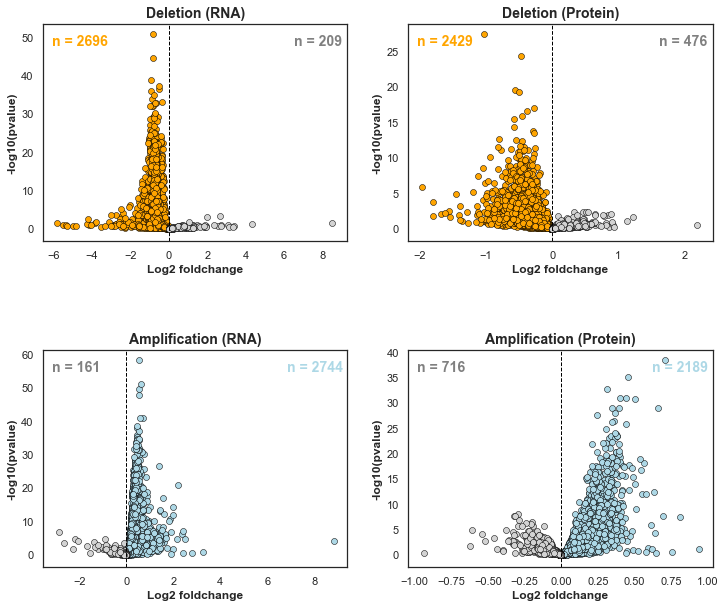

In [29]:
def make_cnv_volc_plot(x_val, y_val, colour, title, num):
    ax = fig.add_subplot(2,2,num)
    if 'Deletion' in title:
        curr_df = df_cnv_pval[lambda x: x[x_val] < 0]
        plot = sns.scatterplot(x=x_val, y=y_val, data=curr_df, color=colour, edgecolor='black', linewidth=0.5)
        plot.text(0.03,0.9, 'n = '+str(len(curr_df)), color=colour, weight='bold', fontsize=14, transform=ax.transAxes)
        curr_df = df_cnv_pval[lambda x: x[x_val] > 0]
        plot = sns.scatterplot(x=x_val, y=y_val, data=curr_df, color='lightgrey', edgecolor='black', linewidth=0.5)
        plot.text(0.825,0.9, 'n = '+str(len(curr_df)), color='grey', weight='bold', fontsize=14, transform=ax.transAxes)
    elif 'Amplification' in title:
        curr_df = df_cnv_pval[lambda x: x[x_val] > 0]
        plot = sns.scatterplot(x=x_val, y=y_val, data=curr_df, color=colour, edgecolor='black', linewidth=0.5)
        plot.text(0.8,0.9, 'n = '+str(len(curr_df)), color=colour, weight='bold', fontsize=14, transform=ax.transAxes)
        curr_df = df_cnv_pval[lambda x: x[x_val] < 0]
        plot = sns.scatterplot(x=x_val, y=y_val, data=curr_df, color='lightgrey', edgecolor='black', linewidth=0.5)
        plot.text(0.03,0.9, 'n = '+str(len(curr_df)), color='grey', weight='bold', fontsize=14, transform=ax.transAxes)
    plot.set_title(title, weight='bold', fontsize=14)
    plot.set_xlabel('Log2 foldchange', weight='bold')
    plot.set_ylabel('-log10(pvalue)', weight='bold')
    plot.axvline(x=0, linestyle='--', color='black', linewidth=1)
    return plot

fig = plt.figure(figsize=[12,10])
plot = make_cnv_volc_plot('rna_fc_del', 'rna_pval_del', 'orange', 'Deletion (RNA)', 1)
plot = make_cnv_volc_plot('prot_fc_del', 'prot_pval_del', 'orange', 'Deletion (Protein)', 2)
plot = make_cnv_volc_plot('rna_fc_amp', 'rna_pval_amp', 'lightblue', 'Amplification (RNA)', 3)
plot = make_cnv_volc_plot('prot_fc_amp', 'prot_pval_amp', 'lightblue', 'Amplification (Protein)', 4)
plt.subplots_adjust(hspace=0.5)
plt.show()

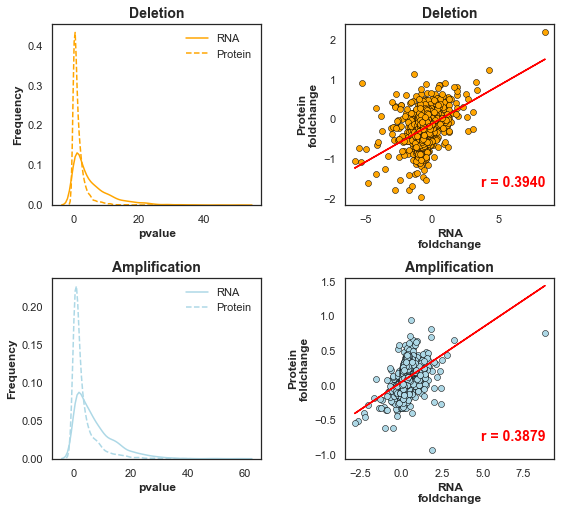

In [873]:
def make_cnv_distplot(val_1, val_2, colour, title, num):
    ax = fig.add_subplot(2,2,num)
    plot = sns.distplot(df_cnv_pval[val_1].dropna(), color=colour, label='RNA', hist=False)
    plot = sns.distplot(df_cnv_pval[val_2].dropna(), color=colour, label='Protein', hist=False, kde_kws={'linestyle':'--'})
    plot.set_title(title, fontsize=14, weight='bold')
    plot.legend(frameon=False)
    plot.set_xlabel('pvalue', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    return plot
def make_cnv_fc_corr_plot(x_val, y_val, color, title, num):
    ax = fig.add_subplot(2,2,num)
    plot = sns.scatterplot(x=x_val, y=y_val, data=df_cnv_pval, color=color, edgecolor='black', linewidth=0.5)
    X = df_cnv_pval[x_val].values.reshape(-1,1)
    y = df_cnv_pval[y_val].values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    plot.plot(X, y, color='red')
    plot.text(0.65, 0.1, 'r = '+format(scipy.stats.pearsonr(df_cnv_pval[x_val], df_cnv_pval[y_val])[0],'.4f'), color='red', transform=ax.transAxes, fontsize=14, weight='bold')
    plot.set_xlabel('RNA\nfoldchange', weight='bold')
    plot.set_ylabel('Protein\nfoldchange', weight='bold')
    plot.set_title(title, fontsize=14, weight='bold')
    return plot

fig = plt.figure(figsize=[9,8])
plot = make_cnv_distplot('rna_pval_del', 'prot_pval_del', 'orange', 'Deletion', 1)
make_cnv_fc_corr_plot('rna_fc_del', 'prot_fc_del', 'orange', 'Deletion', 2)
plot = make_cnv_distplot('rna_pval_amp', 'prot_pval_amp', 'lightblue', 'Amplification', 3)
make_cnv_fc_corr_plot('rna_fc_amp', 'prot_fc_amp', 'lightblue', 'Amplification', 4)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

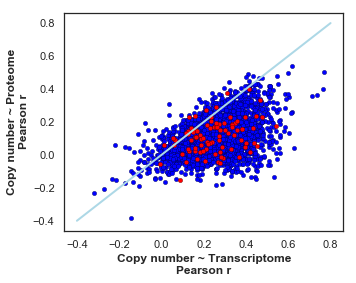

In [947]:
fig = plt.figure(figsize=[5,4])
plot = sns.scatterplot(x='rna_corr',y='prot_corr', data=df_cnv_pval.loc[[x for x in df_cnv_pval.index.tolist() if x not in cancer_proteins]], s=20, color='blue', edgecolor='black', linewidth=0.25)
plot = sns.scatterplot(x='rna_corr',y='prot_corr', data=df_cnv_pval.loc[[x for x in df_cnv_pval.index.tolist() if x  in cancer_proteins]], s=20, color='red', edgecolor='black', linewidth=0.25)
plot.plot([-0.4,0.8],[-0.4,0.8], color='lightblue', linewidth=2)
plot.set_xlabel('Copy number ~ Transcriptome\nPearson r', weight='bold')
plot.set_ylabel('Copy number ~ Proteome\nPearson r', weight='bold')
plt.show()

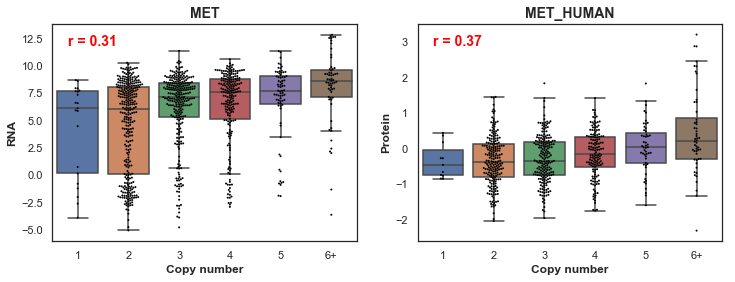

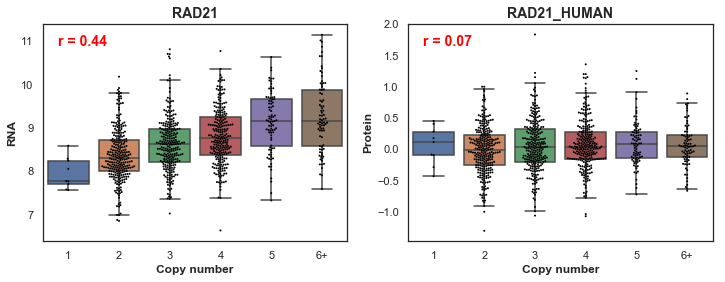

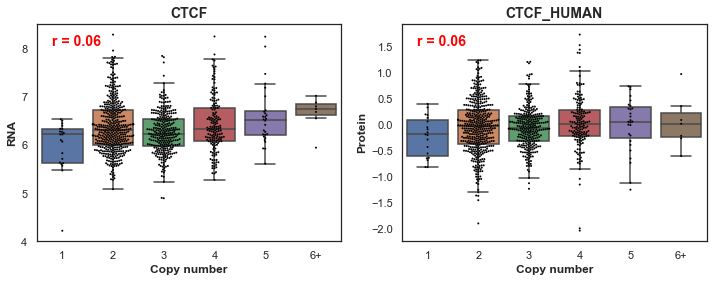

In [33]:
def make_cnv_example_plot(protein, datatype, num):
    gene = protein_to_gene_dict[protein]
    ax = fig.add_subplot(1,2,num)
    if datatype == 'RNA':
        curr_df = df_rna[[protein]].rename(columns={protein:datatype}).join(df_cnv[[gene]].rename(columns={gene:'CNV'})).dropna()
    elif datatype == 'Protein':
        curr_df = df_prot[[protein]].rename(columns={protein:datatype}).join(df_cnv[[gene]].rename(columns={gene:'CNV'})).dropna()
    curr_df['CNV_mod'] = curr_df['CNV']
    curr_df.loc[curr_df[lambda x: x.CNV > 5].index.tolist(), 'CNV_mod'] = '6+'
    plot = sns.boxplot(x='CNV_mod', y=datatype, data=curr_df, showfliers=False, order=[1,2,3,4,5,'6+'])
    plot = sns.swarmplot(x='CNV_mod', y=datatype, data=curr_df, color='black', s=2, order=[1,2,3,4,5,'6+'])
    plot.set_xlabel('Copy number', weight='bold')
    plot.set_ylabel(datatype, weight='bold')
    if datatype == 'RNA':
        corr_val = df_cnv_pval.loc[protein,'rna_corr']
        plot.set_title(gene, fontsize=14, weight='bold')
    elif datatype == 'Protein':
        corr_val = df_cnv_pval.loc[protein,'prot_corr']
        plot.set_title(protein, fontsize=14, weight='bold')
    plot.text(0.05,0.9,'r = '+format(corr_val,'.2f'), color='red', fontsize=14, weight='bold', transform=ax.transAxes)
    return plot

fig = plt.figure(figsize=[12,4])
plot = make_cnv_example_plot('MET_HUMAN', 'RNA', 1)
plot = make_cnv_example_plot('MET_HUMAN', 'Protein', 2)
plt.show()

fig = plt.figure(figsize=[12,4])
plot = make_cnv_example_plot('RAD21_HUMAN', 'RNA', 1)
plot = make_cnv_example_plot('RAD21_HUMAN', 'Protein', 2)
plt.show()

fig = plt.figure(figsize=[12,4])
plot = make_cnv_example_plot('CTCF_HUMAN', 'RNA', 1)
plot = make_cnv_example_plot('CTCF_HUMAN', 'Protein', 2)
plt.show()

### Visualisation

##### PCA

In [2080]:
def make_pca(classification, dtaframe, colour_dict, dict_map, title):

# get data for pca
    df_pca = dtaframe.join(df_cell_map['Tissue_type'])[lambda x: ~(x.Tissue_type.str.contains('Control_HEK293T'))].drop('Tissue_type', axis=1)
    x = df_pca.values.flatten()
    x = x[~np.isnan(x)]
    fill_val = np.percentile(x, 0.001)
    df_pca = df_pca.fillna(fill_val).reset_index()
    df_pca = df_pca.rename(columns = {'Cell_line': 'sample'})
    y0 = df_pca.loc[:,'sample'].values
    x0 = df_pca.iloc[:,1:len(df_pca.columns)]
    x0 = StandardScaler().fit_transform(x0)
    pca = PCA(n_components=5)
    principalComponents = pca.fit_transform(x0)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2','Principal Component 3', 'Principal Component 4','Principal Component 5'])
    df_pca = pd.concat([principalDf, pd.DataFrame(data=y0)], axis = 1).rename(columns={0:'index'}).set_index('index')
    df_pca = df_pca.transpose().rename(columns=dict_map[classification]).transpose().reset_index().rename(columns={'index':'sample'})
    y0 = df_pca.loc[:,'sample'].values
    x0 = df_pca.iloc[:,1:len(df_pca.columns)]
    x0 = StandardScaler().fit_transform(x0)
    pca = PCA(n_components=5)
    principalComponents = pca.fit_transform(x0)
    principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2','Principal Component 3', 'Principal Component 4','Principal Component 5'])
    df_pca = pd.concat([principalDf, pd.DataFrame(data=y0)], axis=1)  

# configure subplots
    fig = plt.figure(figsize = (6,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[8,1],height_ratios=[1,8]) 
    gs.update(wspace=0.01, hspace=0.01)
    
# make horizontal histogram
    ax = plt.subplot(gs[0])
    histx = plt.hist(df_pca['Principal Component 1'], bins=100, color='grey',orientation=u'vertical', edgecolor='black', linewidth=0.5)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    frame1.axis('off')
    ax.set_title(title, weight='bold', fontsize=14)
    
# make pca
    ax = plt.subplot(gs[2])
    ax.set_xlabel('Principal Component 1 \n Variance explained:' + str(round(pca.explained_variance_ratio_[0]*100,1))+ "%", fontsize = 12, weight='bold')
    ax.set_ylabel('Principal Component 2 \n Variance explained:' + str(round(pca.explained_variance_ratio_[1]*100,1))+ "%", fontsize = 12, weight='bold')
    custom_patch = []
    custom_labels = []
    for thing in colour_dict:
        if thing in df_pca[0].unique().tolist():
            indicesToKeep = df_pca[lambda x: x[0] == thing].index.tolist()
            ax.scatter(x = df_pca.loc[indicesToKeep, 'Principal Component 1'], y = df_pca.loc[indicesToKeep, 'Principal Component 2'], c = colour_dict[thing], s = 50, edgecolor='black', linewidth=0.5)
            custom_labels.append(thing)
            custom_patch.append(Patch(facecolor=colour_dict[thing], edgecolor='black', label=''))
    ax.legend(custom_patch, custom_labels, loc=(1.5,0), fontsize=12, frameon=False, ncol=2)
    ax.tick_params(labelsize=12)

# make vertical histogram
    ax = plt.subplot(gs[3])
    histx = plt.hist(df_pca['Principal Component 2'], bins=100, color='grey',orientation=u'horizontal', edgecolor='black', linewidth=0.5)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    frame1.axis('off')
    
# save figure
    plt.show()

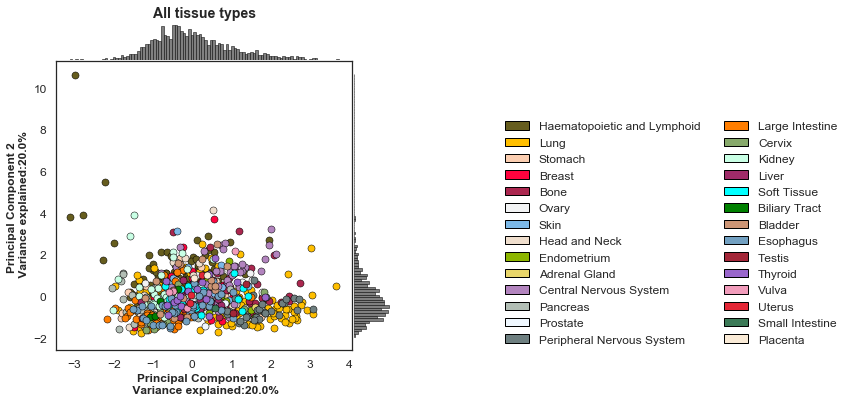

In [2081]:
make_pca('Tissue_type', df_prot, tissue_colours, dict_cell_map, 'All tissue types')

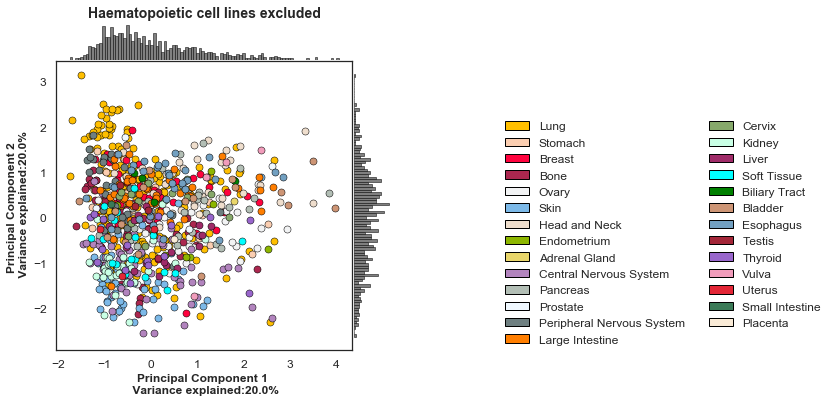

In [2082]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: ~(x.Tissue_type.str.contains('Control_HEK293T')) & ~(x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)
make_pca('Tissue_type', curr_df, tissue_colours, dict_cell_map, 'Haematopoietic cell lines excluded')

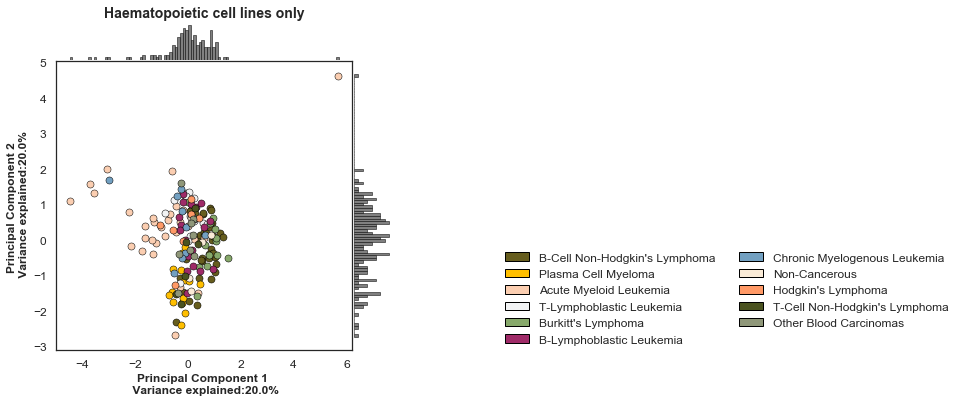

In [2083]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: (x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)
make_pca('Cancer_type', curr_df, cancer_colours, dict_cell_map, 'Haematopoietic cell lines only')

##### tSNE

In [36]:
def make_tsne(classification, dtaframe_tsne, colour_dict, perp, seed, iterations, title, legend):
    x = dtaframe_tsne.values.flatten()
    x = x[~np.isnan(x)]
    fill_val = np.percentile(x, 0.001)
    dtaframe_tsne = dtaframe_tsne.fillna(fill_val).transpose()
    tsne = TSNE(n_components=2, verbose=1, perplexity = 40, random_state = 10, n_iter = 1000)
    tsne_results = tsne.fit_transform(dtaframe_tsne.transpose().values)
    df_tsne = dtaframe_tsne.transpose()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    df_tsne = df_tsne.join(df_cell_map).reset_index()
    df_tsne = df_tsne.set_index(classification)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(2,2,1) 
    ax.set_xlabel('x-tsne', fontsize = 12)
    ax.set_ylabel('y-tsne', fontsize = 12)
    ax.set_title(title, fontsize = 14, weight='bold')
    custom_patch = []
    custom_labels = []
    for thing in colour_dict:
        if thing in df_tsne.index.tolist():
            ax.scatter(df_tsne.loc[thing, 'x-tsne'], df_tsne.loc[thing, 'y-tsne'], c = colour_dict[thing], s = 50, linewidth=1, alpha=1, edgecolor='black')
            if legend == 'Yes':
                custom_labels.append(thing)
                custom_patch.append(Patch(facecolor=colour_dict[thing], edgecolor='black', label=''))
    if legend != 'Yes':
        for thing in legend:
            custom_labels.append(thing)
            custom_patch.append(Patch(facecolor=legend[thing], edgecolor='black', label=''))
    ax.legend(custom_patch, custom_labels, loc=(1.5,0), fontsize=12, frameon=False, ncol=2)
    ax.tick_params(labelsize = 12)
    plt.show()
    
perplexity = 20
random_seed = 42
number_of_iterations = 1000

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 979 samples in 0.156s...
[t-SNE] Computed neighbors for 979 samples in 5.448s...
[t-SNE] Computed conditional probabilities for sample 979 / 979
[t-SNE] Mean sigma: 33.390376
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.967873
[t-SNE] KL divergence after 1000 iterations: 0.917197


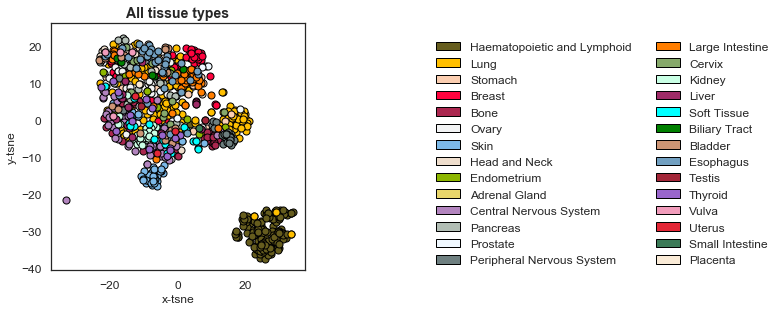

In [37]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: ~(x.Tissue_type.str.contains('Control_HEK293T'))].drop('Tissue_type', axis=1)
make_tsne('Tissue_type', curr_df, tissue_colours, perplexity, random_seed, number_of_iterations, 'All tissue types', 'Yes')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 808 samples in 0.098s...
[t-SNE] Computed neighbors for 808 samples in 4.314s...
[t-SNE] Computed conditional probabilities for sample 808 / 808
[t-SNE] Mean sigma: 32.921526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.505699
[t-SNE] KL divergence after 1000 iterations: 0.991441


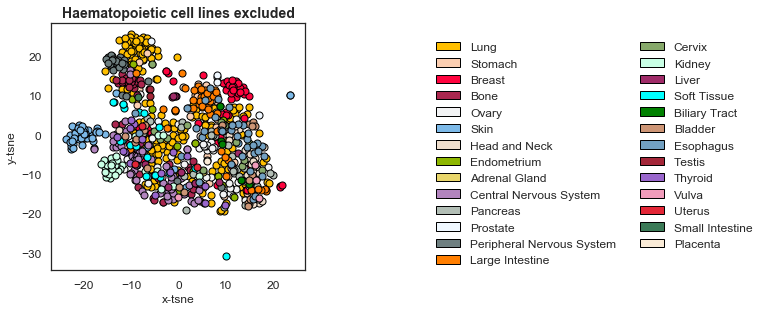

In [2064]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: ~(x.Tissue_type.str.contains('Control_HEK293T')) & ~(x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)
make_tsne('Tissue_type', curr_df, tissue_colours, perplexity, random_seed, number_of_iterations, 'Haematopoietic cell lines excluded', 'Yes')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 171 samples in 0.000s...
[t-SNE] Computed neighbors for 171 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 171 / 171
[t-SNE] Mean sigma: 34.403781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.785103
[t-SNE] KL divergence after 1000 iterations: 0.450181


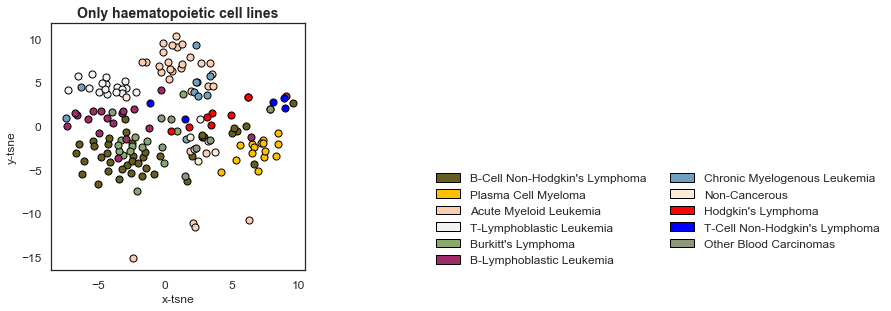

In [2067]:
curr_colours = cancer_colours.copy()
curr_colours["Hodgkin's Lymphoma"] = 'red'
curr_colours["T-Cell Non-Hodgkin's Lymphoma"] = 'blue'
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: (x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)
make_tsne('Cancer_type', curr_df, curr_colours, perplexity, random_seed, number_of_iterations, 'Only haematopoietic cell lines', 'Yes')

##### MDS

In [2290]:
def make_mds(dtaframe, classification, colour_dict, df_map, title):
    distances = sklearn.metrics.pairwise.nan_euclidean_distances(X = dtaframe)
    mds = sklearn.manifold.MDS(dissimilarity = 'precomputed')
    transformed = pd.DataFrame(mds.fit_transform(distances), columns=['x','y'], index=dtaframe.index).join(df_map[classification])
    fig = plt.figure(figsize=[5,5])
    plot = sns.scatterplot(x='x',y='y',hue=classification, data=transformed, palette=colour_dict, s=50, edgecolor='black')
    custom_patch = []
    custom_labels = []
    for thing in colour_dict:
        if thing in transformed[classification].unique().tolist():
            custom_labels.append(thing)
            custom_patch.append(Patch(facecolor=colour_dict[thing], edgecolor='black', label=''))
    plot.legend(custom_patch, custom_labels, loc=(1.5,0), fontsize=12, frameon=False, ncol=2)
    plot.set_title(title, fontsize=14, weight='bold')
    plt.show()

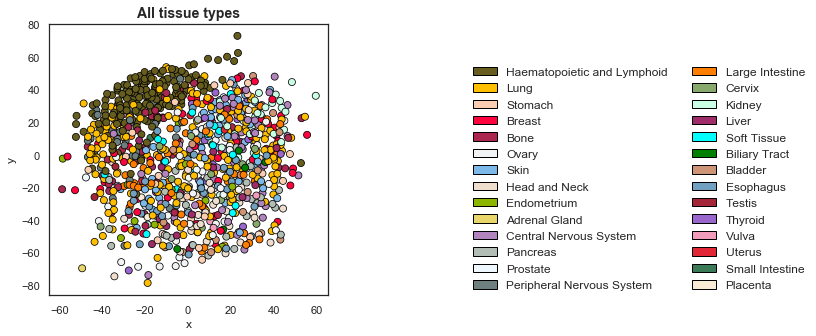

In [2291]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: ~x.Tissue_type.str.contains('Control_HEK293T')].drop('Tissue_type',axis=1)
make_mds(curr_df, 'Tissue_type', tissue_colours, df_cell_map, 'All tissue types')

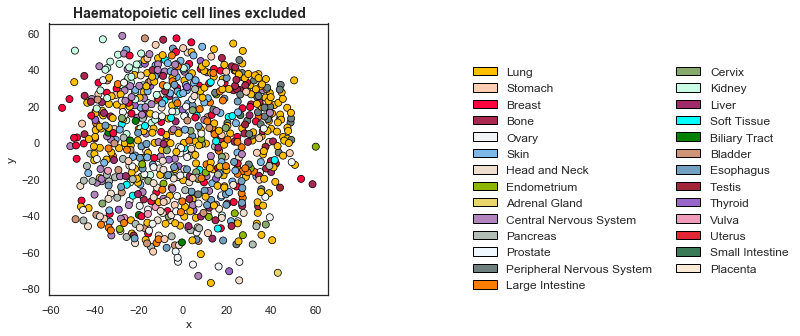

In [2292]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: (~x.Tissue_type.str.contains('Control_HEK293T')) & (~x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type',axis=1)
make_mds(curr_df, 'Tissue_type', tissue_colours, df_cell_map, 'Haematopoietic cell lines excluded')

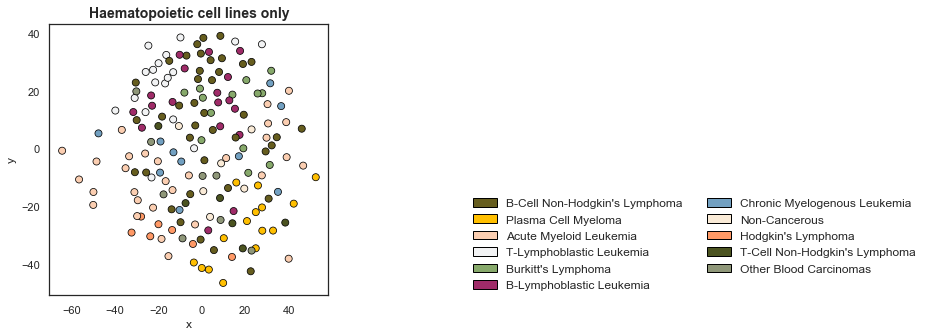

In [2293]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: x.Tissue_type.str.contains('Haematopoietic')].drop('Tissue_type',axis=1)
make_mds(curr_df, 'Cancer_type', cancer_colours, df_cell_map, 'Haematopoietic cell lines only')

##### Heatmap

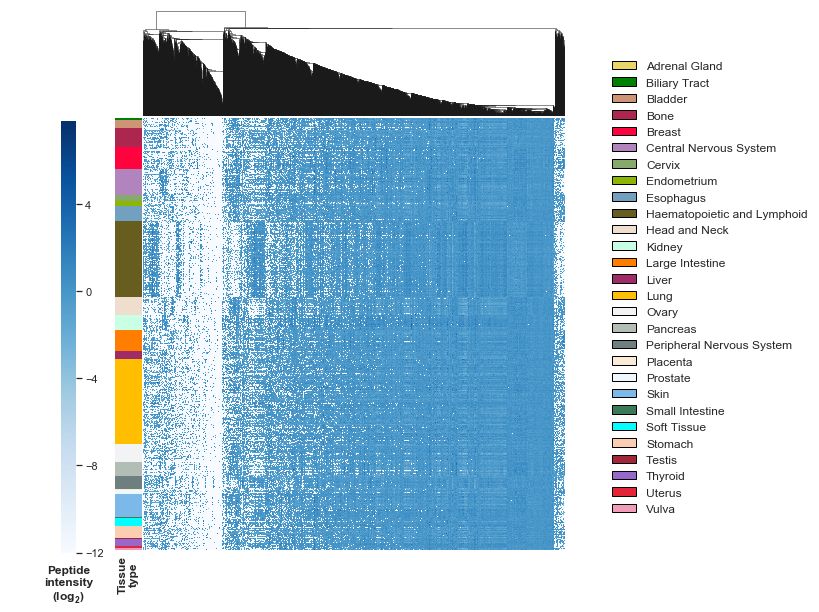

In [208]:
curr_df = df_prot.join(df_cell_map['Tissue_type']).sort_values('Tissue_type')[lambda x: x.Tissue_type != 'Control_HEK293T'].drop('Tissue_type',axis=1).reset_index().rename(columns={'Cell_line':''}).set_index('')
curr_df = curr_df.fillna(df_prot.min().min())
curr_df_colours = df_colours.join(df_sample_map['Cell_line'])[['Tissue_type','Cell_line']].drop_duplicates().set_index('Cell_line').rename(columns={'Tissue_type':''})
plot = sns.clustermap(curr_df, row_cluster=False, col_cluster=True, xticklabels=False, yticklabels=False, cmap=plt.cm.Blues, row_colors=curr_df_colours)
plot.cax.set_position((0.2,0.12,0.02,0.6))
plt.xlabel('\nPeptide\nintensity\n(log'+'$\mathregular{_2}$'+')', weight='bold')
for tissue in sorted(tissue_colours):
    if tissue != 'Control_HEK293T':
        plot.ax_col_dendrogram.bar(0, 0, color=tissue_colours[tissue], label=tissue, linewidth=1, edgecolor='black')
plot.ax_col_dendrogram.legend(bbox_to_anchor=(1.6,0.6), ncol=1, fontsize=12, frameon=False)
plt.text(80,-13,'Tissue\ntype', weight='bold', rotation=90, ha='center')
plt.show()

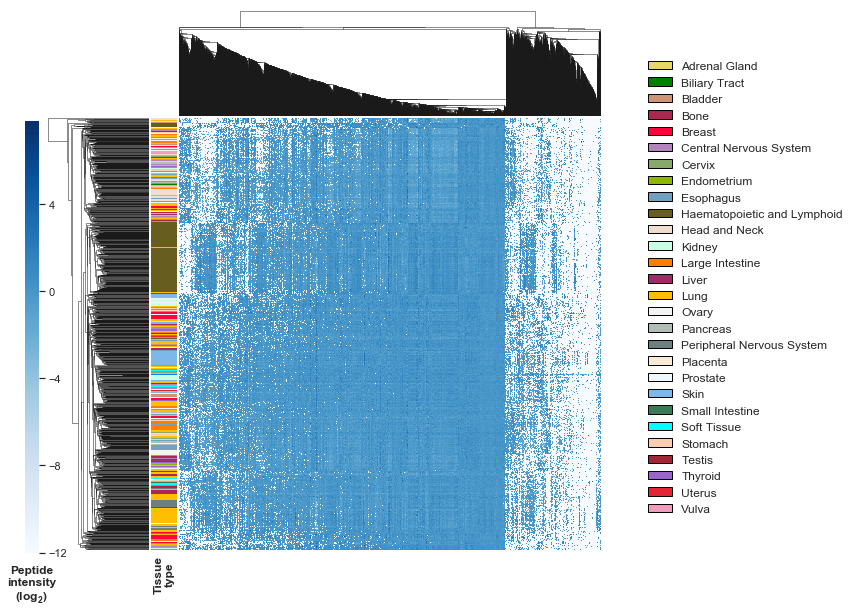

In [209]:
curr_df = df_prot.fillna(df_prot.min().min()).reset_index().rename(columns={'Cell_line':''}).set_index('')
curr_df_colours = df_colours.join(df_sample_map['Cell_line'])[['Tissue_type','Cell_line']].drop_duplicates().set_index('Cell_line').rename(columns={'Tissue_type':''})
plot = sns.clustermap(curr_df, row_cluster=True, col_cluster=True, xticklabels=False, yticklabels=False, cmap=plt.cm.Blues, row_colors=curr_df_colours)
plot.cax.set_position((0.1,0.12,0.02,0.6))
plt.xlabel('\nPeptide\nintensity\n(log'+'$\mathregular{_2}$'+')', weight='bold')
for tissue in sorted(tissue_colours):
    if tissue != 'Control_HEK293T':
        plot.ax_col_dendrogram.bar(0, 0, color=tissue_colours[tissue], label=tissue, linewidth=1, edgecolor='black')
plot.ax_col_dendrogram.legend(bbox_to_anchor=(1.6,0.6), ncol=1, fontsize=12, frameon=False)
plt.text(180,-13,'Tissue\ntype', weight='bold', rotation=90, ha='center')
plt.show()

### Correlations with other datasets

In [205]:
def compare_two_datasets(dtaframe_A, name_A, dtaframe_B, name_B):
    
    # Create datasets
    rna_corr_cell_A = get_rna_protein_correlation_cellwise(dtaframe_A)
    rna_corr_prot_A = get_rna_protein_correlation_proteinwise(dtaframe_A)
    rna_corr_cell_B = get_rna_protein_correlation_cellwise(dtaframe_B)
    rna_corr_prot_B = get_rna_protein_correlation_proteinwise(dtaframe_B)
    common_lines = [x for x in dtaframe_A.index.tolist() if x in dtaframe_B.index.tolist()]
    common_proteins = [x for x in dtaframe_A.columns.tolist() if x in dtaframe_B.columns.tolist()]
    fig = plt.figure(figsize=[16,8])
    
    # Correlation by cell line (distplot) - comparison of datasets
    ax = fig.add_subplot(2,3,1)
    df_corr_cell = pd.DataFrame()
    for cell_line in common_lines:
        curr_df = dtaframe_A.transpose()[[cell_line]].rename(columns={cell_line:name_A}).join(dtaframe_B.transpose()[[cell_line]].rename(columns={cell_line:'ProCan'})).dropna()
        df_corr_cell.loc[cell_line,'Correlation'] = scipy.stats.pearsonr(curr_df[name_A],curr_df[name_B])[0]
    plot = sns.distplot(df_corr_cell['Correlation'], color='blue', label=format(df_corr_cell['Correlation'].median(),'.2f'))
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_title('RNA-protein correlations by cell line\n('+str(len(common_lines))+' cell lines)', weight='bold', fontsize=14)
    plt.legend(frameon=False, fontsize=14)
    
    # Correlation by protein (distplot) - comparison of datasets
    ax = fig.add_subplot(2,3,4)
    df_corr_prot = pd.DataFrame()
    for protein in common_proteins:
        curr_df = dtaframe_A[[protein]].rename(columns={protein:name_A}).join(dtaframe_B[[protein]].rename(columns={protein:'ProCan'})).dropna()
        if len(curr_df) > 1:
            df_corr_prot.loc[protein,'Correlation'] = scipy.stats.pearsonr(curr_df[name_A],curr_df[name_B])[0]
    plot = sns.distplot(df_corr_prot['Correlation'], color='blue', label=format(df_corr_prot['Correlation'].median(),'.2f'))
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_title('RNA-protein correlations by protein\n('+str(len(common_proteins))+' proteins)', weight='bold', fontsize=14)
    plt.legend(frameon=False, fontsize=14)
    
    # Correlation by cell line (distplot) - both datasets shown
    ax = fig.add_subplot(2,3,2)
    plot = sns.distplot(rna_corr_cell_A['Correlation'], color='green', label=name_A+' '+str(format(rna_corr_cell_A['Correlation'].median(),'.2f'))+'\n('+str(len(rna_corr_cell_A))+' cell lines)')
    plot = sns.distplot(rna_corr_cell_B['Correlation'], color='orange', label=name_B+' '+str(format(rna_corr_cell_B['Correlation'].median(),'.2f'))+'\n('+str(len(rna_corr_cell_B))+' cell lines)')
    plot.axvline(x=rna_corr_cell_A['Correlation'].median(), linestyle='--', linewidth=2, color='green')
    plot.axvline(x=rna_corr_prot_B['Correlation'].median(), linestyle='--', linewidth=2, color='orange')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_title('RNA-protein correlations by cell line', weight='bold', fontsize=14)
    plt.legend(frameon=False, fontsize=14)
    
    # Correlation by protein (distplot) - both datasets shown
    ax = fig.add_subplot(2,3,5)
    plot = sns.distplot(rna_corr_prot_A['Correlation'], color='green', label=name_A+' '+str(format(rna_corr_prot_A['Correlation'].median(),'.2f'))+'\n('+str(len(rna_corr_prot_A))+' proteins)')
    plot = sns.distplot(rna_corr_prot_B['Correlation'], color='orange', label=name_B+' '+str(format(rna_corr_prot_B['Correlation'].median(),'.2f'))+'\n('+str(len(rna_corr_prot_B))+' proteins)')
    plot.axvline(x=rna_corr_prot_A['Correlation'].median(), linestyle='--', linewidth=2, color='green')
    plot.axvline(x=rna_corr_prot_B['Correlation'].median(), linestyle='--', linewidth=2, color='orange')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_title('RNA-protein correlations by protein\n('+str(len(common_lines))+' cell lines)', weight='bold', fontsize=14)
    plt.legend(frameon=False, fontsize=14)

    # Correlation by cell line (scatter plot) - both datasets shown
    ax = fig.add_subplot(2,3,3)
    curr_df = rna_corr_cell_B.rename(columns={'Correlation':name_B}).join(rna_corr_cell_A.rename(columns={'Correlation':name_A})).dropna()
    plot = sns.scatterplot(x=name_B,y=name_A,data=curr_df, color='blue')
    plot.plot([0,1],[0,1], color='black', linestyle='--')
    plot.set_xlabel(name_B, weight='bold')
    plot.set_ylabel(name_A, weight='bold')
    plot.set_title('Cell-line correlations\n(n = '+str(len(common_lines))+' cell lines)', fontsize=14, weight='bold')
    
    # Correlation by protein (scatter plot) - both datasets shown
    ax = fig.add_subplot(2,3,6)
    curr_df = rna_corr_prot_A.rename(columns={'Correlation':name_A}).join(rna_corr_prot_B.rename(columns={'Correlation':name_B}))[lambda x: x.index.isin(cancer_proteins)]
    plot = sns.scatterplot(x=name_B,y=name_A,data=curr_df, color='blue')
    plot.plot([0,1],[0,1], color='black', linestyle='--')
    plot.set_xlabel('RNA~protein correlation\n'+name_B, weight='bold')
    plot.set_ylabel(name_A+' \nRNA~protein correlation', weight='bold')
    plot.set_title('Protein-wise comparison\n('+str(len(common_lines))+' cell lines and '+str(len(curr_df.index.tolist()))+' cancer-related proteins)', fontsize=14, weight='bold')
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()

##### Nusinow et al (Broad) CCLE data

In [179]:
df_broad = pd.read_csv(source_folder+'protein_quant_current_normalized.csv.gz')
df_broad = df_broad.drop(['Protein_Id','Gene_Symbol','Description','Group_ID','Uniprot_Acc'], axis=1).rename(columns={'Uniprot':'Protein'}).set_index('Protein')
df_broad = df_broad.drop(['SW948_LARGE_INTESTINE_TenPx11','CAL120_BREAST_TenPx02','HCT15_LARGE_INTESTINE_TenPx30'], axis=1)
rename_dict = {}
for x in df_broad.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
df_broad = df_broad.rename(columns=rename_dict)
df_broad = df_broad.drop([x for x in df_broad.columns.tolist() if 'TenPx' in x], axis=1).transpose()
df_broad = df_broad[[x for x in df_broad.columns.tolist() if df_broad.columns.tolist().count(x) == 1]]
curr_dict = df_sample_map[['CCLE_ID','Cell_line']].drop_duplicates().set_index('CCLE_ID').to_dict()['Cell_line']
df_broad.index = df_broad.index.map(curr_dict)
common_lines_broad = [x for x in df_broad.index.tolist() if x in df_prot.index.tolist()]
print('Number of common cell lines: ',len(common_lines_broad))

Number of common cell lines:  295


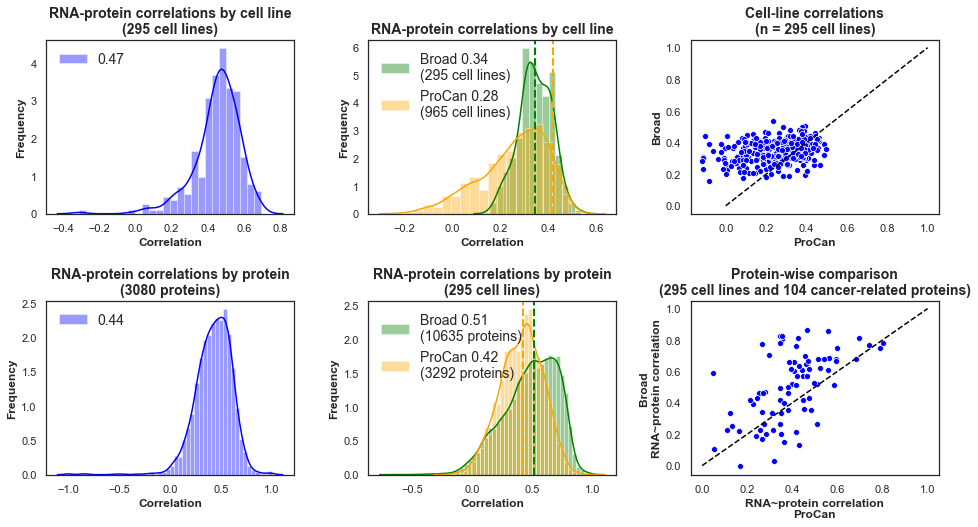

In [188]:
compare_two_datasets(df_broad, 'Broad', df_prot, 'ProCan')

##### Guo et al (NCI-60) data

In [40]:
df_nci60 = pd.read_csv(source_folder+'nci60_protV15.txt', sep='\t').set_index('prot')
rename_dict = {}
for x in df_nci60.columns.to_list():
    rename_dict[x] = x.split('_')[1]
df_nci60 = df_nci60.rename(columns=rename_dict)
# pd.DataFrame(index=df_nci60.index.tolist()).reset_index().to_csv(source_folder+'nci60_protein_ids.txt')
nci60_protein_map = pd.read_csv(source_folder+'nci60_protein_mapping.txt', sep='\t').set_index('Entry').to_dict()['Entry name']
df_nci60.index = df_nci60.index.map(nci60_protein_map)
df_nci60 = df_nci60.transpose().reset_index().groupby('index').mean().apply(np.log2)
nci60_common_lines = [x for x in df_prot.index.tolist() if x in df_nci60.index.tolist()]
print('Number of commmon lines:',len(nci60_common_lines))

Number of commmon lines: 19


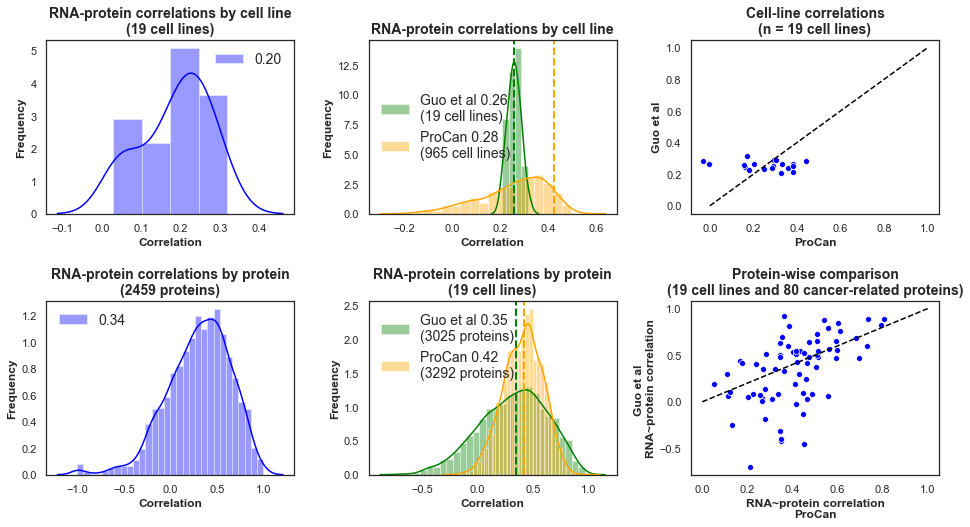

In [41]:
compare_two_datasets(df_nci60, 'Guo et al', df_prot, 'ProCan')

##### Lawrence TNBC cell lines

In [173]:
df_brca = pd.read_excel(source_folder+'Lawrence_TableS1_BrCa.xlsx', sheet_name='TableS1')
df_brca.columns = df_brca.iloc[2]
df_brca[['sp','uniprot','Protein']] = df_brca['Uniprot Entry'].str.split('|', expand=True)
df_brca[['Protein','other']] = df_brca['Protein'].str.split(' ', 1, expand=True)
df_brca = df_brca.set_index('Protein').drop(['Uniprot Entry','sp','uniprot','other'], axis=1).transpose().reset_index()
df_brca[['Cell_line','other']] = df_brca[2].str.split(' ', 1, expand=True)
df_brca = df_brca.set_index('Cell_line').drop(['other',2],axis=1).transpose()[lambda x: ~x.index.isna()].transpose().astype(float).reset_index()
df_brca = df_brca.groupby('Cell_line').mean().apply(np.log2)
df_brca = df_brca[[x for x in df_brca.columns.tolist() if df_brca.columns.tolist().count(x) == 1]]

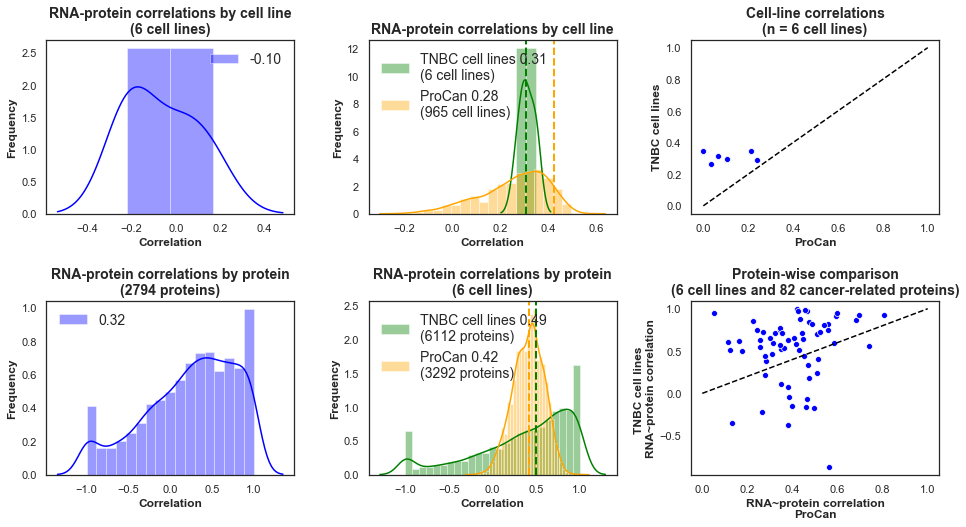

In [43]:
compare_two_datasets(df_brca, 'TNBC cell lines', df_prot, 'ProCan')

###### Roumeliotis et al (CRC)

In [44]:
df_crc = pd.read_excel(source_folder+'Roumeliotis_TableS1_CRC.xlsx', sheet_name='COREAD_Proteome')
df_crc.columns = df_crc.iloc[0]
df_crc = df_crc.set_index('Accession').drop('Accession').drop(['FDR<0.1','ANOVA p value','log2(meanMut/meanWT)','essential colon cancer gene? (OGEE database)','FDR<0.1','ANOVA p value','log2(meanCNA/meanWT)','Identifier','Recurrent\nGain/Loss','locus'], axis=1)
df_crc['Protein'] = df_crc['Gene name'].map(gene_to_protein_dict)
df_crc = df_crc.set_index('Protein')[lambda x: ~x.index.isna()].drop('Gene name', axis=1).transpose()
df_crc = df_crc[[x for x in df_crc.columns.tolist() if df_crc.columns.tolist().count(x) == 1]]

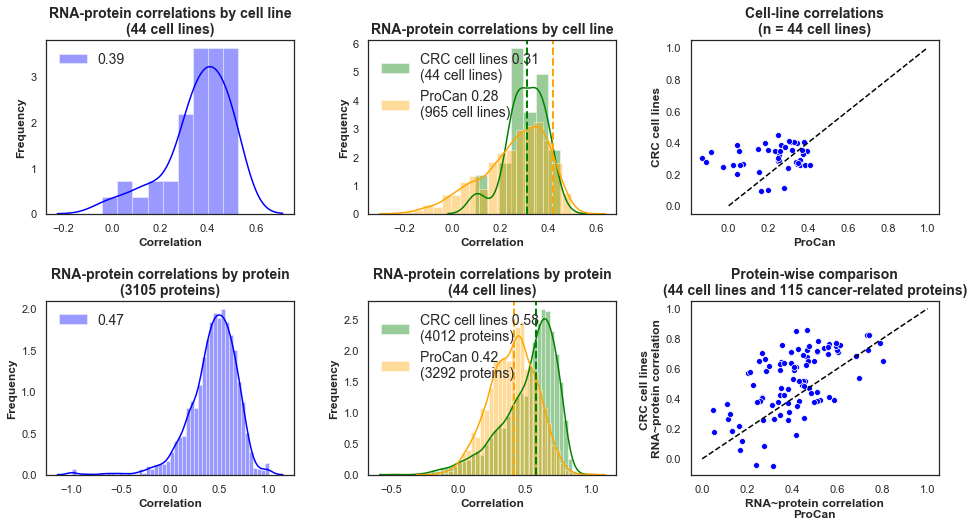

In [45]:
compare_two_datasets(df_crc, 'CRC cell lines', df_prot, 'ProCan')

### Correlations with CPTAC data

In [341]:
def correlate_with_cptac(tissue_type, cancer_type, input_dtaframe, input_dict):
    df_cptac = input_dtaframe.copy()
    df_cptac.index = df_cptac.index.map(input_dict)
    df_cptac = df_cptac[~df_cptac.index.isna()]
    df_cptac = df_cptac.reset_index().groupby('protein_name').mean().transpose()
    df_prot_tissue = df_prot_raw.loc[df_cell_map[lambda x: x.Tissue_type.str.contains(tissue_type)].index.tolist()]
    curr_df = df_prot_tissue.mean().to_frame('ProCan').join(df_cptac.mean().to_frame('CPTAC')).dropna()
    plot = sns.scatterplot(x='ProCan', y='CPTAC', data=curr_df, color='blue', edgecolor='black', linewidth=0.5)
    plot.text(0.05,0.05,'r = '+format(scipy.stats.pearsonr(curr_df['ProCan'],curr_df['CPTAC'])[0],'.4f'), color='red', fontsize=14, weight='bold', transform=plot.transAxes)
    plot.set_xlabel('ProCan', weight='bold')
    plot.set_ylabel('CPTAC', weight='bold')
    X = curr_df['ProCan'].values.reshape(-1,1)
    y = curr_df['CPTAC'].values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    plot.plot(X, y, color='red')
    plot.set_title(cancer_type+' cell lines ~ CPTAC '+cancer_type, weight='bold', fontsize=14)
    plt.show()
    return df_cptac

In [346]:
def correlate_with_cptac_lowCV(tissue_type, cancer_type, input_dtaframe, input_proteins):
    df_cptac = input_dtaframe.copy()
    df_prot_tissue = df_prot_raw.loc[df_cell_map[lambda x: x.Tissue_type.str.contains(tissue_type)].index.tolist()]
    curr_df = df_prot_tissue.mean().to_frame('ProCan').join(df_cptac.mean().to_frame('CPTAC')).dropna().loc[input_proteins]
    plot = sns.scatterplot(x='ProCan', y='CPTAC', data=curr_df, color='blue', edgecolor='black', linewidth=0.5)
    plot.text(0.05,0.05,'r = '+format(scipy.stats.pearsonr(curr_df['ProCan'],curr_df['CPTAC'])[0],'.4f'), color='red', fontsize=14, weight='bold', transform=plot.transAxes)
    plot.set_xlabel('ProCan', weight='bold')
    plot.set_ylabel('CPTAC', weight='bold')
    X = curr_df['ProCan'].values.reshape(-1,1)
    y = curr_df['CPTAC'].values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    plot.plot(X, y, color='red')
    plot.set_title(cancer_type+' cell lines ~ CPTAC '+cancer_type+'\n(n = '+str(len(input_proteins))+' proteins)', weight='bold', fontsize=14)
    plt.show()

In [347]:
def get_pairwise_cptac_correlations(tissue_type, cancer_type, input_dtaframe):
    df_prot_tissue = df_prot_raw.loc[df_cell_map[lambda x: x.Tissue_type.str.contains(tissue_type)].index.tolist()]
    curr_list = []
    for cptac_sample in input_dtaframe.index.tolist():
        for procan_sample in df_prot_tissue.index.tolist():
            curr_df = input_dtaframe.transpose()[[cptac_sample]].join(df_prot_tissue.transpose()[[procan_sample]]).dropna()
            curr_list.append(scipy.stats.pearsonr(curr_df[cptac_sample],curr_df[procan_sample])[0])
    plot = sns.distplot(curr_list, color='blue')
    plot.axvline(x=np.median(curr_list), color='red', linestyle='--', linewidth=1)
    plot.text(0.05,0.9,'r = '+format(np.median(curr_list),'.4f'), transform=plot.transAxes, color='red', weight='bold', fontsize=14)
    plot.set_title('Pairwise correlations\n'+cancer_type+' cell lines ~ CPTAC '+cancer_type, weight='bold', fontsize=14)
    plt.show()

##### Breast cancer

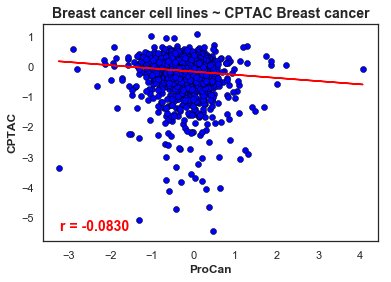

In [344]:
df_brca_cptac = pd.read_excel(source_folder+'CPTAC_BC_SupplementaryTable03.xlsx', sheet_name='Global-Proteome-G3')
df_brca_cptac = df_brca_cptac.rename(columns={'accession_number':'protein_name'}).set_index('protein_name')[[x for x in df_brca_cptac.columns.tolist() if 'TCGA' in x]]
pd.DataFrame(index=df_brca_cptac.index.unique().tolist()).reset_index().to_csv(source_folder+'CPTAC_BRCA_protein_list.txt', index=False, header=None)
cptac_brca_map = pd.read_csv(source_folder+'CPTAC_BRCA_protein-map.tab', sep='\t').rename(columns={'yourlist:M20200513216DA2B77BFBD2E6699CA9B6D1C41EB287E5333':'From','Entry name':'To'})[['From','To']].set_index('From')
cptac_brca_dict = {}
for x in cptac_brca_map.index.tolist():
    for protein in x.split(','):
        if type(cptac_brca_map.loc[x,'To']) == str:
            cptac_brca_dict[protein] = cptac_brca_map.loc[x,'To']
df_brca_cptac = correlate_with_cptac('Breast', 'Breast cancer', df_brca_cptac, cptac_brca_dict)

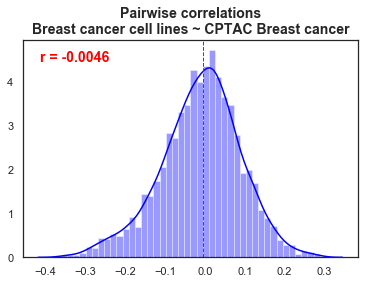

In [348]:
get_pairwise_cptac_correlations('Breast', 'Breast cancer', df_brca_cptac)

##### Ovarian cancer

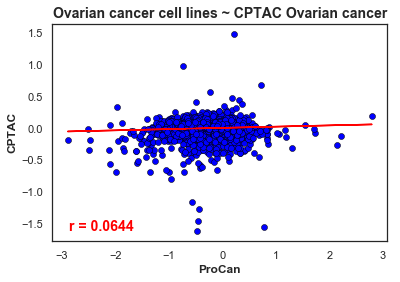

In [349]:
df_ov_cptac = pd.read_excel(source_folder+'CPTAC_OV_protein_data.xlsx', sheet_name='FullOvarianProteomeData')
df_ov_cptac = df_ov_cptac.rename(columns={'refseq_peptide':'protein_name'}).set_index('protein_name')[[x for x in df_ov_cptac.columns.tolist() if 'TCGA' in x]]
pd.DataFrame(index=df_ov_cptac.index.unique().tolist()).reset_index().to_csv(source_folder+'CPTAC_OV_protein_list.txt', index=False, header=None)
cptac_ov_map = pd.read_csv(source_folder+'CPTAC_OV_protein-map.tab', sep='\t').rename(columns={'yourlist:M20200514A94466D2655679D1FD8953E075198DA8C015B9E':'From','Entry name':'To'})[['From','To']].set_index('From')
cptac_ov_dict = {}
for x in cptac_ov_map.index.tolist():
    for protein in x.split(','):
        if type(cptac_ov_map.loc[x,'To']) == str:
            cptac_ov_dict[protein] = cptac_ov_map.loc[x,'To']
df_ov_cptac = correlate_with_cptac('Ovary', 'Ovarian cancer', df_ov_cptac, cptac_ov_dict)

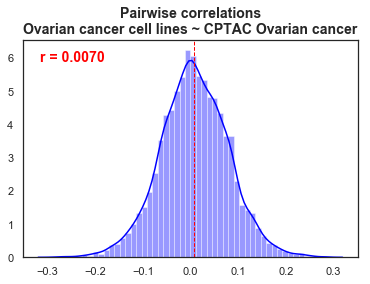

In [350]:
get_pairwise_cptac_correlations('Ovary', 'Ovarian cancer', df_ov_cptac)

##### Colorectal cancer

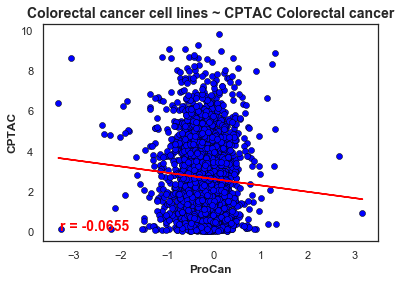

In [351]:
df_crc_cptac = pd.read_excel(source_folder+'CPTAC_CRC_protein_data.xlsx', sheet_name='S4_sample95_count_quantilelog')
df_crc_cptac = df_crc_cptac.rename(columns={'GeneSymbol':'protein_name'}).set_index('protein_name')[[x for x in df_crc_cptac.columns.tolist() if 'TCGA' in x]]
pd.DataFrame(index=df_crc_cptac.index.unique().tolist()).reset_index().to_csv(source_folder+'CPTAC_CRC_protein_list.txt', index=False, header=None)
cptac_crc_map = pd.read_csv(source_folder+'CPTAC_CRC_protein-map.tab', sep='\t').rename(columns={'yourlist:M20200514A94466D2655679D1FD8953E075198DA8C02931O':'From','Entry name':'To'})[['From','To']].set_index('From')
cptac_crc_dict = cptac_crc_map.to_dict()['To']
df_crc_cptac = correlate_with_cptac('Intestine', 'Colorectal cancer', df_crc_cptac, cptac_crc_dict)

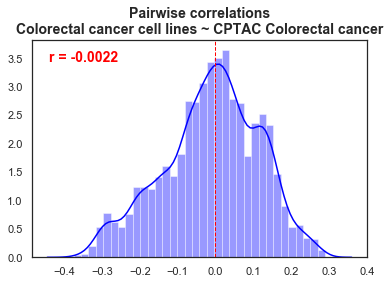

In [352]:
get_pairwise_cptac_correlations('Intestine', 'Colorectal cancer', df_crc_cptac)

##### Correlations across tissue types

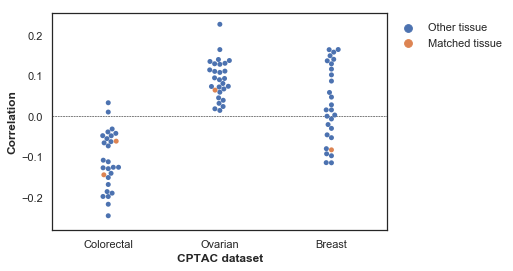

In [353]:
df_corr_cptac = pd.DataFrame()
cptac_dict = {'Colorectal':df_crc_cptac, 'Ovarian':df_ov_cptac, 'Breast':df_brca_cptac}
for tissue in [x for x in df_cell_map['Tissue_type'].unique().tolist() if 'Control_HEK293T' not in x]:
    curr_df = df_prot_raw.loc[df_cell_map[lambda x: x.Tissue_type == tissue].index.tolist()]
    for val in cptac_dict:
        tmp_df = curr_df.mean().to_frame('ProCan').join(cptac_dict[val].mean().to_frame('CPTAC')).dropna()
        df_corr_cptac.loc[tissue, val] = scipy.stats.pearsonr(tmp_df['ProCan'], tmp_df['CPTAC'])[0]
curr_df = df_corr_cptac.unstack().to_frame('Correlation').reset_index().rename(columns={'level_1':'Tissue','level_0':'Dataset'})
curr_df['Colour'] = 'Other tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Colorectal') & (x.Tissue == 'Small Intestine')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Colorectal') & (x.Tissue == 'Large Intestine')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Ovarian') & (x.Tissue == 'Ovary')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Breast') & (x.Tissue == 'Breast')].index.tolist()[0],'Colour'] = 'Matched tissue'
plot = sns.swarmplot(x='Dataset', y='Correlation', data=curr_df, hue='Colour')
plot.set_xlabel('CPTAC dataset', weight='bold')
plot.set_ylabel('Correlation', weight='bold')
plot.legend(bbox_to_anchor=[1,1], frameon=False)
plot.axhline(y=0, linestyle='--', color='black', linewidth=0.5)
plt.show()

##### Correlate proteins with lowest CVs

In [354]:
cv_cptac_brca = df_brca_cptac.apply(lambda x: 2**x).apply(lambda x: x.std()/x.mean()*100).to_frame('BRCA').dropna()
cv_cptac_ov = df_ov_cptac.apply(lambda x: 2**x).apply(lambda x: x.std()/x.mean()*100).to_frame('OV').dropna()
cv_cptac_crc = df_crc_cptac.apply(lambda x: 2**x).apply(lambda x: x.std()/x.mean()*100).to_frame('CRC').dropna()
cv_prot = df_prot_raw.apply(lambda x: 2**x).apply(lambda x: x.std()/x.mean()*100).to_frame('ProCan').dropna()
low_cv_brca_cptac = cv_cptac_brca[lambda x: x.BRCA < np.percentile(cv_cptac_brca['BRCA'], 25)].index.tolist()
low_cv_ov_cptac = cv_cptac_ov[lambda x: x.OV < np.percentile(cv_cptac_ov['OV'], 25)].index.tolist()
low_cv_crc_cptac = cv_cptac_crc[lambda x: x.CRC < np.percentile(cv_cptac_crc['CRC'], 25)].index.tolist()
low_cv_prot = cv_prot[lambda x: x.ProCan < np.percentile(cv_prot['ProCan'], 25)].index.tolist()
common_low_cv_proteins = [x for x in low_cv_prot if x in low_cv_brca_cptac and  x in low_cv_ov_cptac and x in low_cv_crc_cptac]

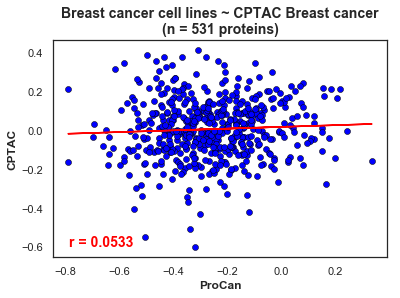

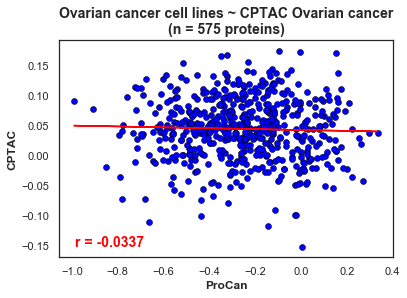

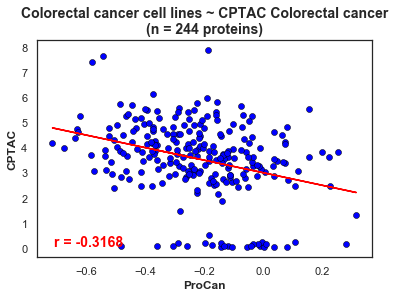

In [355]:
correlate_with_cptac_lowCV('Breast', 'Breast cancer', df_brca_cptac, [x for x in low_cv_brca_cptac if x in low_cv_prot])
correlate_with_cptac_lowCV('Ovary', 'Ovarian cancer', df_ov_cptac, [x for x in low_cv_ov_cptac if x in low_cv_prot])
correlate_with_cptac_lowCV('Intestine', 'Colorectal cancer', df_crc_cptac, [x for x in low_cv_crc_cptac if x in low_cv_prot])

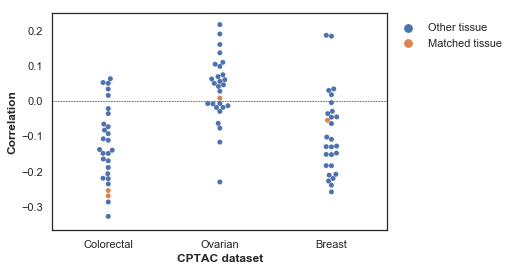

In [356]:
df_corr_cptac = pd.DataFrame()
cptac_dict = {'Colorectal':df_crc_cptac, 'Ovarian':df_ov_cptac, 'Breast':df_brca_cptac}
for tissue in [x for x in df_cell_map['Tissue_type'].unique().tolist() if 'Control_HEK293T' not in x]:
    curr_df = df_prot_raw.loc[df_cell_map[lambda x: x.Tissue_type == tissue].index.tolist()]
    for val in cptac_dict:
        tmp_df = curr_df.mean().to_frame('ProCan').join(cptac_dict[val].mean().to_frame('CPTAC')).loc[common_low_cv_proteins].dropna()
        df_corr_cptac.loc[tissue, val] = scipy.stats.pearsonr(tmp_df['ProCan'], tmp_df['CPTAC'])[0]
curr_df = df_corr_cptac.unstack().to_frame('Correlation').reset_index().rename(columns={'level_1':'Tissue','level_0':'Dataset'})
curr_df['Colour'] = 'Other tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Colorectal') & (x.Tissue == 'Small Intestine')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Colorectal') & (x.Tissue == 'Large Intestine')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Ovarian') & (x.Tissue == 'Ovary')].index.tolist()[0],'Colour'] = 'Matched tissue'
curr_df.loc[curr_df[lambda x: (x.Dataset == 'Breast') & (x.Tissue == 'Breast')].index.tolist()[0],'Colour'] = 'Matched tissue'
plot = sns.swarmplot(x='Dataset', y='Correlation', data=curr_df, hue='Colour')
plot.set_xlabel('CPTAC dataset', weight='bold')
plot.set_ylabel('Correlation', weight='bold')
plot.legend(bbox_to_anchor=[1,1], frameon=False)
plot.axhline(y=0, linestyle='--', color='black', linewidth=0.5)
plt.show()

In [474]:
def plot_correlations_of_proteins(protein_A, protein_B, dtaframe, dataset):
    curr_df = dtaframe[[protein_A,protein_B]].dropna()
    plot = sns.scatterplot(x=protein_A, y=protein_B, data=curr_df, color='blue')
    plot.set_xlabel(protein_A, weight='bold')
    plot.set_ylabel(protein_B, weight='bold')
    plot.set_title(dataset+'\n'+protein_A+' ~ '+protein_B, fontsize=14, weight='bold')
    X = curr_df[protein_A].values.reshape(-1,1)
    y = curr_df[protein_B].values.reshape(-1,1)
    regressor = LinearRegression()  
    regressor.fit(X, y)
    y = regressor.predict(X)
    plot.plot(X, y, color='red')
    plot.text(0.05, 0.05, 'r = '+format(scipy.stats.pearsonr(curr_df[protein_A], curr_df[protein_B])[0],'.4f'), color='red', weight='bold', fontsize=14, transform=plot.transAxes)
    return plot

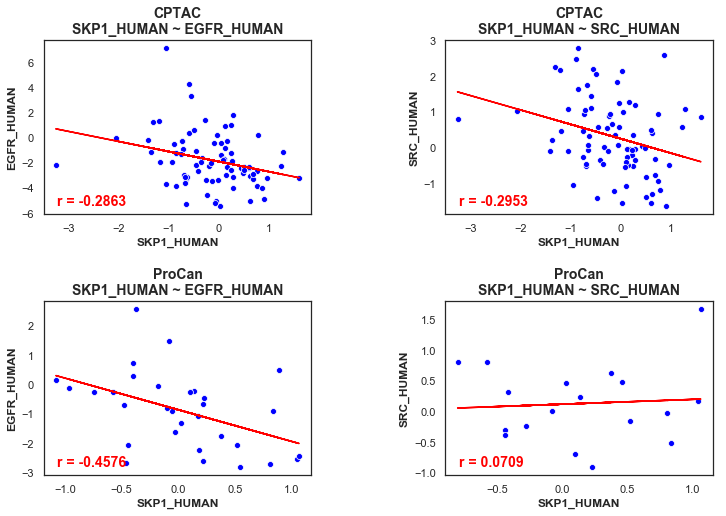

In [479]:
fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2,2,1)
plot = plot_correlations_of_proteins('SKP1_HUMAN', 'EGFR_HUMAN', df_brca_cptac, 'CPTAC')
ax = fig.add_subplot(2,2,2)
plot = plot_correlations_of_proteins('SKP1_HUMAN', 'SRC_HUMAN', df_brca_cptac, 'CPTAC')

ax = fig.add_subplot(2,2,3)
plot = plot_correlations_of_proteins('SKP1_HUMAN', 'EGFR_HUMAN', df_prot.loc[df_cell_map[lambda x: x.Tissue_type == 'Breast'].index.tolist()], 'ProCan')
ax = fig.add_subplot(2,2,4)
plot = plot_correlations_of_proteins('SKP1_HUMAN', 'SRC_HUMAN', df_prot.loc[df_cell_map[lambda x: x.Tissue_type == 'Breast'].index.tolist()], 'ProCan')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

### Protein complex correlations

In [495]:
protein_to_id_dict = pd.read_csv(source_folder+'master_protein_list_uniprotID.tab.gz', sep='\t').set_index('Entry').to_dict()['Entry name']
df_corum = pd.read_csv(source_folder+'coreComplexes.txt', sep='\t')
df_corum['Test'] =  df_corum['subunits(UniProt IDs)'].apply(lambda x: len([s for s in x if s==';'])==1)
df_corum_pair = df_corum[df_corum.Test][['ComplexName','subunits(UniProt IDs)']]
df_corum_pair[['Protein_A','Protein_B']] = df_corum_pair['subunits(UniProt IDs)'].str.split(';',expand=True)
df_corum_pair['Protein_A'] = df_corum_pair['Protein_A'].map(protein_to_id_dict)
df_corum_pair['Protein_B'] = df_corum_pair['Protein_B'].map(protein_to_id_dict)
df_corum_pair = df_corum_pair.drop('subunits(UniProt IDs)', axis=1)[lambda x: x.Protein_A.isin(df_prot.columns.tolist()) & x.Protein_B.isin(df_prot.columns.tolist())].set_index('ComplexName').drop_duplicates()
corum_duplexes = df_corum_pair.index.tolist()
corum_duplexes = [x for x in corum_duplexes if corum_duplexes.count(x) == 1]
df_corum_pair = df_corum_pair.loc[corum_duplexes]
print('Number of CORUM duplexes with protein data:',len(corum_duplexes))

Number of CORUM duplexes with protein data: 124


In [496]:
df_corum_corr = pd.DataFrame()
for duplex in corum_duplexes:
    protein_A = df_corum_pair.loc[duplex,'Protein_A']
    protein_B = df_corum_pair.loc[duplex,'Protein_B']
    curr_df = df_prot[[protein_A,protein_B]].dropna()
    df_corum_corr.loc[duplex,'Correlation'] = scipy.stats.pearsonr(curr_df[protein_A], curr_df[protein_B])[0]
df_corum_corr_rand = pd.DataFrame()
curr_proteins = df_prot.columns.tolist()
for n in range(0,1000):
    random.shuffle(curr_proteins)
    curr_df = df_prot[[curr_proteins[0],curr_proteins[1]]].dropna()
    if len(curr_df) > 3:
        df_corum_corr_rand.loc[n,'Correlation'] = scipy.stats.pearsonr(curr_df[curr_proteins[0]], curr_df[curr_proteins[1]])[0]
    else:
        random.shuffle(curr_proteins)
        curr_df = df_prot[[curr_proteins[0],curr_proteins[1]]].dropna()
        df_corum_corr_rand.loc[n,'Correlation'] = scipy.stats.pearsonr(curr_df[curr_proteins[0]], curr_df[curr_proteins[1]])[0]

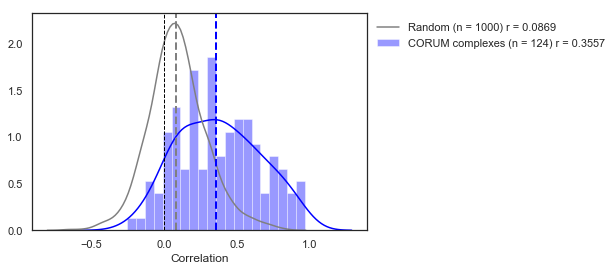

In [497]:
plot = sns.distplot(df_corum_corr['Correlation'], bins=20, color='blue', label='CORUM complexes (n = '+str(len(df_corum_corr))+') r = '+format(df_corum_corr['Correlation'].median(),'.4f'))
plot = sns.distplot(df_corum_corr_rand['Correlation'], bins=20, color='grey', label='Random (n = '+str(len(df_corum_corr_rand))+') r = '+format(df_corum_corr_rand['Correlation'].median(),'.4f'), hist=False)
plot.axvline(x=df_corum_corr_rand['Correlation'].median(), linestyle='--', color='grey', linewidth=2)
plot.axvline(x=df_corum_corr['Correlation'].median(), linestyle='--', color='blue', linewidth=2) 
plot.axvline(x=0, linestyle='--', color='black', linewidth=1) 
plot.legend(frameon=False, bbox_to_anchor=(1,1))
plt.show()

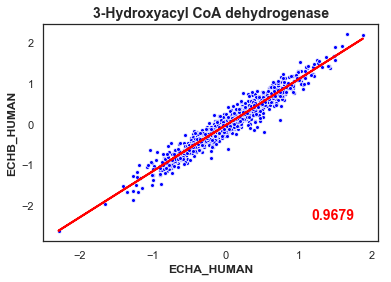

In [498]:
best_complex = df_corum_corr.sort_values('Correlation', ascending=False).index.tolist()[0]
best_protein_A = df_corum_pair.loc[best_complex]['Protein_A']
best_protein_B = df_corum_pair.loc[best_complex]['Protein_B']
curr_df = df_prot[[best_protein_A, best_protein_B]].dropna()

X = curr_df[best_protein_A].values.reshape(-1,1)
y = curr_df[best_protein_B].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

plot = sns.scatterplot(x=best_protein_A, y=best_protein_B, data=curr_df, color='blue', s=15)
plot.set_xlabel(best_protein_A, weight='bold')
plot.set_ylabel(best_protein_B, weight='bold')
plot.set_title(best_complex, weight='bold', fontsize=14)
plot.text(0.8, 0.1, format(df_corum_corr.loc[best_complex,'Correlation'],'.4f'), color='red', weight='bold', transform=plot.transAxes, fontsize=14)
plot.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

### Mismatch repair analysis

In [1098]:
def make_msi_plot(dtaframe, protein, num):
    curr_df = dtaframe[[protein]].join(df_cell_map['MSI_status']).sort_values('MSI_status', ascending=False)[lambda x: x.MSI_status != 'Control_HEK293T'].dropna()
    ax = fig.add_subplot(1,4,num)
    plot = sns.boxplot(x='MSI_status', y=protein, data=curr_df, showfliers=False)
    plot.set_xlabel('MSI_status', weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(protein, weight='bold', fontsize=14)
    ylim_1 = plot.get_ylim()[0]
    ylim_2 = plot.get_ylim()[1]
    diff = ylim_2 - ylim_1
    plot.plot([0,1],[ylim_2+diff*0.05,ylim_2+diff*0.05], linewidth=1, color='black')
    pval = scipy.stats.ttest_ind(curr_df[lambda x: x.MSI_status == 'MSS'][protein], curr_df[lambda x: x.MSI_status == 'MSI'][protein])[1]
    plot.text(0.5,ylim_2+diff*0.1, format(pval,'.4f'), ha='center')
    plot.set_ylim(ylim_1,ylim_2+diff*0.2)
    return plot

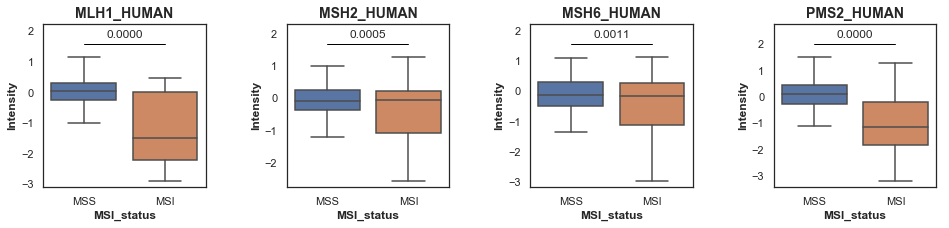

In [1099]:
fig = plt.figure(figsize=[16,3])
plot = make_msi_plot(df_broad, 'MLH1_HUMAN',1)
plot = make_msi_plot(df_broad, 'MSH2_HUMAN',2)
plot = make_msi_plot(df_broad, 'MSH6_HUMAN',3)
plot = make_msi_plot(df_broad, 'PMS2_HUMAN',4)
plt.subplots_adjust(wspace=0.5)
plt.show()

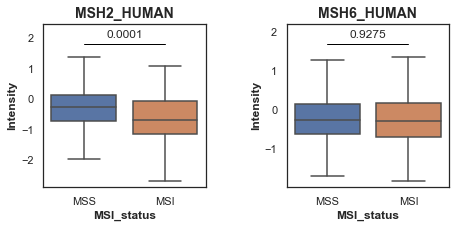

In [1100]:
fig = plt.figure(figsize=[16,3])
plot = make_msi_plot(df_prot, 'MSH2_HUMAN',1)
plot = make_msi_plot(df_prot, 'MSH6_HUMAN',2)
plt.subplots_adjust(wspace=0.5)
plt.show()

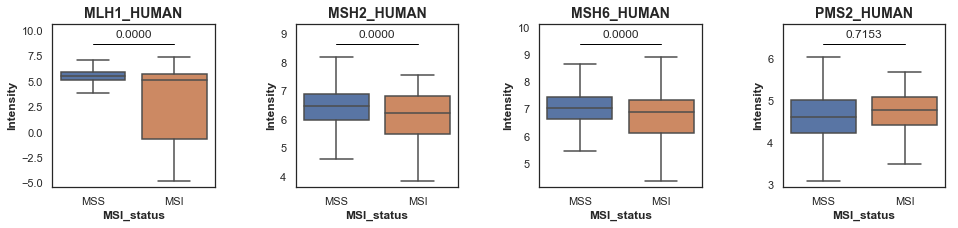

In [1101]:
fig = plt.figure(figsize=[16,3])
plot = make_msi_plot(df_rna, 'MLH1_HUMAN',1)
plot = make_msi_plot(df_rna, 'MSH2_HUMAN',2)
plot = make_msi_plot(df_rna, 'MSH6_HUMAN',3)
plot = make_msi_plot(df_rna, 'PMS2_HUMAN',4)
plt.subplots_adjust(wspace=0.5)
plt.show()

### Cancer driver mutations

##### Import cancer drivers

In [ ]:
df_mut = pd.read_csv(source_folder+'WES_variants.csv.gz')
deleterious_muts = ['missense','frameshift','nonsense']
mutated_proteins = df_mut.groupby('Gene').count().to_dict()['SAMPLE']
for gene in [x for x in mutated_proteins if x in gene_to_protein_dict and gene_to_protein_dict[x] in df_rna.columns.tolist() and gene_to_protein_dict[x] in df_prot.columns.tolist()]:
    mutated_proteins[gene_to_protein_dict[gene]] = mutated_proteins[gene]
for gene in df_mut['Gene'].unique().tolist():
    del mutated_proteins[gene]

##### Generate volcano plots based on wildtype and mutant samples

In [209]:
samples_of_interest = [x for x in df_mut['model_id'].unique().tolist() if x in df_cell_map['SIDM'].unique().tolist()]
df_mut_stats = pd.DataFrame()
for protein in mutated_proteins:
    gene = protein_to_gene_dict[protein]

    poss_mt_samples = df_mut[lambda x: x.Gene == gene]['model_id'].unique().tolist()
    mt_samples = df_mut[lambda x: (x.Gene == gene) & (x.Classification.isin(deleterious_muts))]['model_id'].unique().tolist()
    mt_samples = [sidm_dict[x] for x in mt_samples if x in samples_of_interest]
    wt_samples = [sidm_dict[x] for x in samples_of_interest if x not in poss_mt_samples]

    df_mt_prot = df_prot[[protein]].loc[mt_samples].dropna()
    df_wt_prot = df_prot[[protein]].loc[wt_samples].dropna()
    df_mut_stats.loc[protein,'pvalue_prot'] = np.log10(scipy.stats.ttest_ind(df_mt_prot[protein], df_wt_prot[protein])[1])*-1
    df_mut_stats.loc[protein,'foldchange_prot'] = df_mt_prot[protein].median() - df_wt_prot[protein].median()

    df_mt_rna = df_rna[[protein]].loc[mt_samples].dropna()
    df_wt_rna = df_rna[[protein]].loc[wt_samples].dropna()
    df_mut_stats.loc[protein,'pvalue_rna'] = np.log10(scipy.stats.ttest_ind(df_mt_rna[protein], df_wt_rna[protein])[1])*-1
    df_mut_stats.loc[protein,'foldchange_rna'] = df_mt_rna[protein].median() - df_wt_rna[protein].median()

    df_mut_stats.loc[protein,'wt_num_total'] = len(wt_samples)
    df_mut_stats.loc[protein,'mt_num_total'] = len(mt_samples)
    wt_present = len(df_wt_prot)
    mt_present = len(df_mt_prot)
    df_mut_stats.loc[protein,'wt_num_val'] = wt_present
    df_mut_stats.loc[protein,'mt_num_val'] = mt_present
    wt_missing = len(wt_samples) - len(df_wt_prot)
    mt_missing = len(mt_samples) - len(df_mt_prot)
    df_mut_stats.loc[protein,'wt_num_missing'] = wt_missing
    df_mut_stats.loc[protein,'mt_num_missing'] = mt_missing
    if wt_missing > 0 and mt_missing > 0 and wt_present > 0 and mt_present > 0:
        df_mut_stats.loc[protein,'missing_chi_pval'] = scipy.stats.chi2_contingency(np.array([[wt_present,wt_missing], [mt_present,mt_missing]]))[1]
    else: 
        df_mut_stats.loc[protein,'missing_chi_pval'] = 0
    df_mut_stats['wt_mean'] = df_mut_stats['wt_num_missing']/df_mut_stats['wt_num_total']
    df_mut_stats['mt_mean'] = df_mut_stats['mt_num_missing']/df_mut_stats['mt_num_total']
    df_mut_stats['chi_fc'] = df_mut_stats['wt_mean']/df_mut_stats['mt_mean']
    df_mut_stats['-log10_missing_chi_pval'] = np.log10(df_mut_stats['missing_chi_pval'])*-1
df_mut_stats = df_mut_stats.sort_values('mt_num_val', ascending=False).dropna()
df_mut_stats['missing_total'] = df_mut_stats['wt_num_missing'] + df_mut_stats['mt_num_missing']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 fo

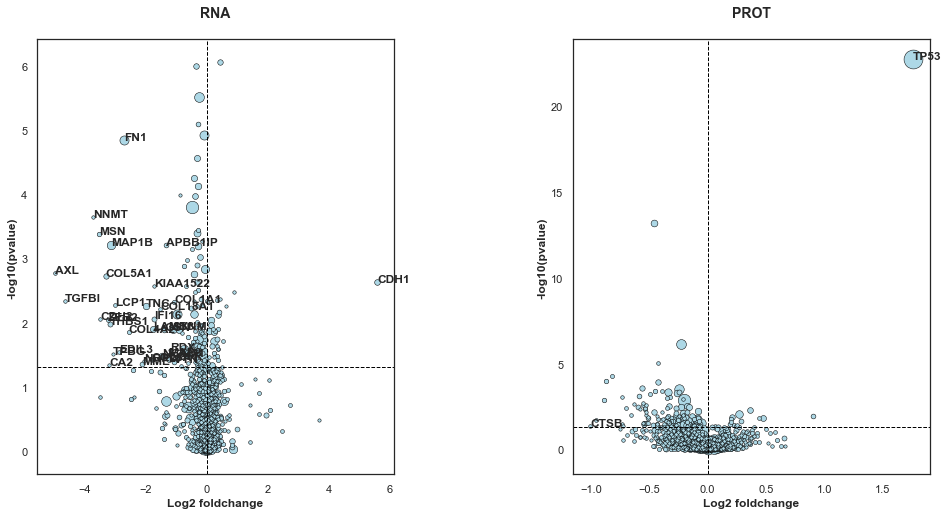

In [210]:
def make_mutation_volcano_plot(dtatype, fc_val, num):
    ax = fig.add_subplot(1,2,num)
    for protein in df_mut_stats[lambda x: x.mt_num_val > 10].index.tolist():
        plot = sns.scatterplot(x='foldchange_'+dtatype, y='pvalue_'+dtatype, data=df_mut_stats.transpose()[[protein]].transpose(), s=df_mut_stats.loc[protein,'mt_num_val'], color='lightblue', edgecolor='black', linewidth=0.5)
        if abs(df_mut_stats.loc[protein,'foldchange_'+dtatype]) > fc_val and df_mut_stats.loc[protein,'pvalue_'+dtatype] > np.log10(0.05)*-1:
            plot.text(df_mut_stats.loc[protein,'foldchange_'+dtatype], df_mut_stats.loc[protein,'pvalue_'+dtatype], protein_to_gene_dict[protein], weight='bold')
    plot.set_xlabel('Log2 foldchange', weight='bold')
    plot.set_ylabel('-log10(pvalue)', weight='bold')
    plot.set_title(dtatype.upper()+'\n', fontsize=14, weight='bold')
    plot.axvline(x=0, linestyle='--', linewidth=1, color='black')
    plot.axhline(y=np.log10(0.05)*-1, linestyle='--', linewidth=1, color='black')

fig = plt.figure(figsize=[16,8])
make_mutation_volcano_plot('rna', 1, 1)
make_mutation_volcano_plot('prot', 1, 2)
plt.subplots_adjust(wspace=0.5)
plt.show()

In [212]:
samples_of_interest = [sidm_dict[x] for x in df_mut['model_id'].unique().tolist() if x in df_cell_map['SIDM'].unique().tolist()]

def plot_mut_status(dtaframe, protein, title, mt_samples):
    gene = protein_to_gene_dict[protein]
    curr_df = dtaframe[[protein]].dropna()
    curr_df = curr_df.loc[[x for x in curr_df.index.tolist() if 'Control_HEK293T' not in str(x)]]
    poss_mt_samples = [sidm_dict[x] for x in df_mut[lambda x: x.Gene == protein_to_gene_dict[protein]]['model_id'].unique().tolist() if x in sidm_dict and sidm_dict[x] in samples_of_interest]
    curr_df.loc[[x for x in curr_df.index.tolist() if x not in poss_mt_samples and x in samples_of_interest], 'mut_status'] = 'Wildtype'
    curr_df.loc[[x for x in mt_samples if x in curr_df.index.tolist() and x in samples_of_interest],'mut_status'] = 'Mutant'
    curr_df = curr_df.dropna()
    plot = sns.boxplot(x='mut_status', y=protein, data=curr_df.sort_values('mut_status', ascending=False), showfliers=False)
    plot.set_xticklabels([p.get_text()+'\nn = '+str(len(curr_df[lambda x: x.mut_status == p.get_text()])) for p in plot.get_xticklabels()])
    pval = scipy.stats.ttest_ind(curr_df[lambda x: x.mut_status == 'Wildtype'][protein], curr_df[lambda x: x.mut_status == 'Mutant'][protein])[1]
    ylim_1 = plot.get_ylim()[0]
    ylim_2 = plot.get_ylim()[1]
    diff = ylim_2 - ylim_1
    plot.plot([0,1],[ylim_2+diff*0.05,ylim_2+diff*0.05], linewidth=1, color='black')
    plot.text(0.5,ylim_2+diff*0.1, format(pval,'.4f'), ha='center')
    plot.set_ylim(ylim_1,ylim_2+diff*0.2)
    plot.set_xlabel('')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(title+'\n\n'+gene, weight='bold', fontsize=14)
    return plot

def generate_mut_comparisons(gene): 
    protein = gene_to_protein_dict[gene]
    mt_samples = df_mut[lambda x: (x.Gene == gene) & (x.Classification.isin(deleterious_muts))]['model_id']
    mt_samples = list(set([sidm_dict[x] for x in mt_samples if x in sidm_dict]))
    fig = plt.figure(figsize=[12,4])
    ax = fig.add_subplot(1,3,1)
    plot = plot_mut_status(df_rna, protein, 'RNA (Sanger)', mt_samples)
    ax = fig.add_subplot(1,3,2)
    plot = plot_mut_status(df_prot, protein, 'Protein (ProCan)', mt_samples)
    ax = fig.add_subplot(1,3,3)
    plot = plot_mut_status(df_broad, protein, 'Protein (Broad)', mt_samples)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

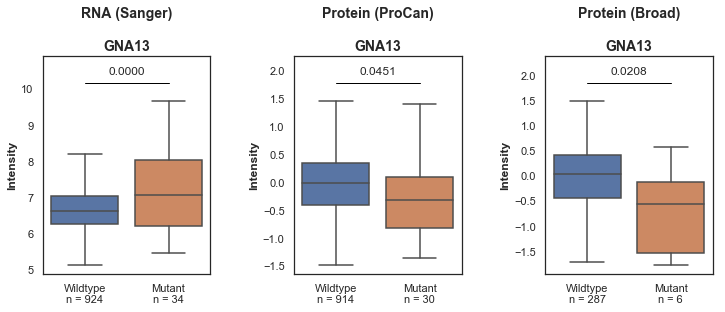

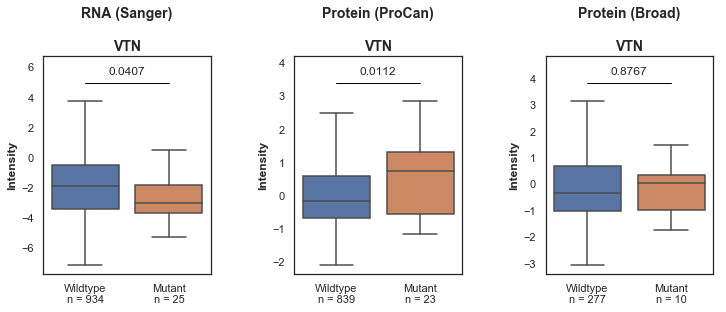

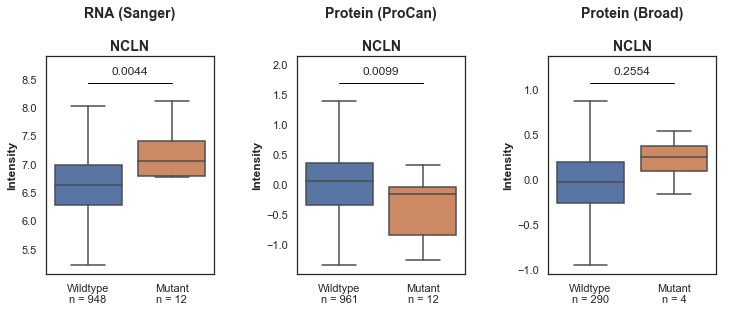

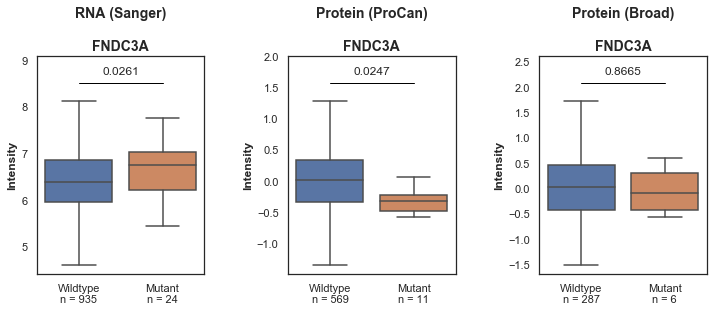

In [213]:
opp_effect = df_mut_stats[lambda x: (x.pvalue_prot > (np.log10(0.05)*-1)) & (x.pvalue_rna > (np.log10(0.05)*-1)) & (x.mt_num_val > 5) & (x.foldchange_prot*x.foldchange_rna < 0)].index.tolist()
for x in opp_effect:
    generate_mut_comparisons(protein_to_gene_dict[x])

##### Plot example fold changes

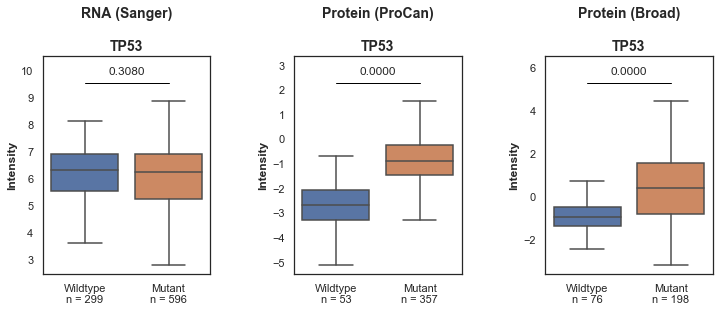

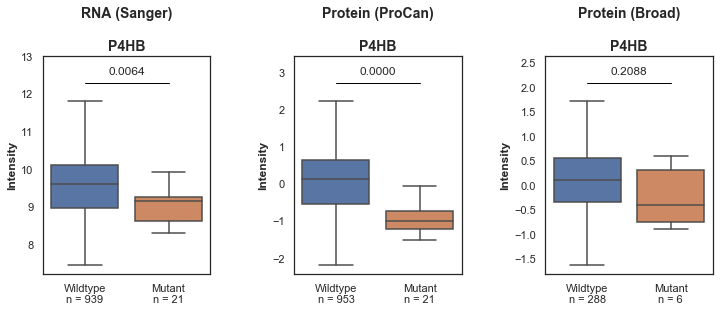

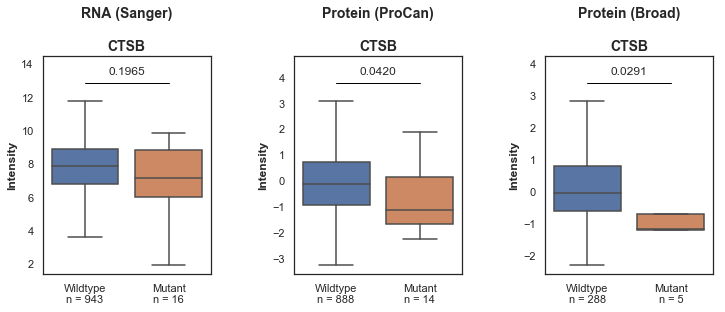

In [214]:
generate_mut_comparisons('TP53')
generate_mut_comparisons('P4HB')
generate_mut_comparisons('CTSB')

##### Examine TP53 mutations

In [215]:
df_p53 = df_mut[lambda x: x.Gene == 'TP53']
df_p53_freq = df_p53.groupby('AA').size().to_frame('Freq')[lambda x: (x.Freq > 5) & (x.index != 'p.?')]
common_p53_mut = df_p53_freq.index.tolist()
df_p53_count = df_p53.groupby('SAMPLE').size().to_frame('Freq')
samples_p53_mt = [x for x in df_p53_count[lambda x: x.Freq == 1].index.tolist() if x in df_prot.index.tolist()]
samples_p53_wt = [x for x in df_prot.index.tolist() if x not in df_p53_count.index.tolist()]

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


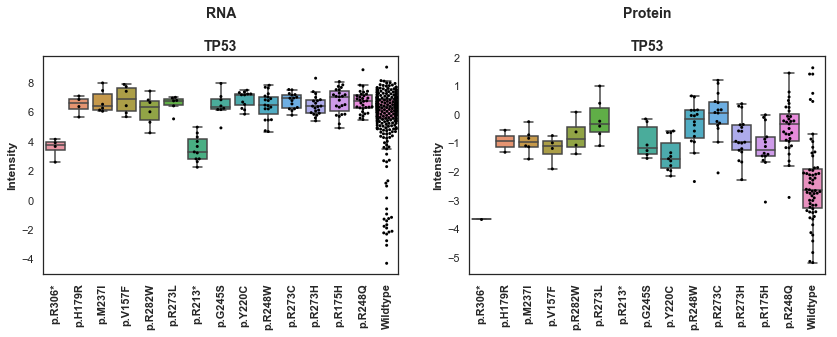

In [216]:
def make_tp53_plot(dataframe, datatype):
    curr_df = dataframe.loc[(samples_p53_wt + samples_p53_mt),'P53_HUMAN'].to_frame('P53_HUMAN')
    curr_df = curr_df.join(df_p53.set_index('SAMPLE').loc[samples_p53_mt,'AA']).rename(columns={'AA':'Mutation'})
    curr_df.loc[samples_p53_wt,'Mutation'] = 'Wildtype'
    curr_df = curr_df[lambda x: (x.Mutation.isin(common_p53_mut)) | (x.Mutation == 'Wildtype')]
    curr_df['Frequency'] = curr_df['Mutation'].map(df_p53_freq.to_dict()['Freq'])
    curr_df.sort_values('Frequency', inplace=True)
    plot = sns.boxplot(x='Mutation', y='P53_HUMAN', data=curr_df, showfliers=False)
    plot = sns.swarmplot(x='Mutation', y='P53_HUMAN', data=curr_df, color='black', s=3)
    plot.set_xlabel('')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90, weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(datatype+'\n\nTP53', weight='bold',fontsize=14)
fig = plt.figure(figsize=[14,4])
ax = fig.add_subplot(1,2,1)
make_tp53_plot(df_rna, 'RNA')
ax = fig.add_subplot(1,2,2)
make_tp53_plot(df_prot, 'Protein')
plt.show()

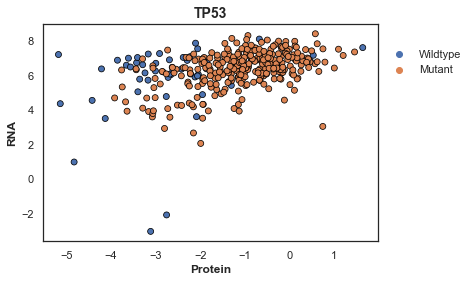

In [223]:
curr_df = df_prot[['P53_HUMAN']].rename(columns={'P53_HUMAN':'Protein'}).join(df_rna[['P53_HUMAN']].rename(columns={'P53_HUMAN':'RNA'}))
curr_df['Protein'] = curr_df['Protein'].astype(float)
curr_df['RNA'] = curr_df['RNA'].astype(float)
curr_df.loc[samples_p53_wt,' '] = 'Wildtype'
curr_df.loc[samples_p53_mt,' '] = 'Mutant'
curr_df = curr_df.dropna().sort_values(' ', ascending=False)
plot = sns.scatterplot(x='Protein', y='RNA', hue=' ', data=curr_df, edgecolor='black')
plot.set_xlabel('Protein', weight='bold')
plot.set_ylabel('RNA', weight='bold')
plot.set_title('TP53', weight='bold', fontsize=14)
plot.legend(bbox_to_anchor=(1,1), frameon=False)
plt.show()

##### Cascade effects (upregulation)

In [229]:
df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna > 1) & (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot > 1)]

pvalue_prot  foldchange_prot  pvalue_rna  foldchange_rna  \
CEAM6_HUMAN     1.726027         2.410917    1.399002         4.58931   

             wt_num_total  mt_num_total  wt_num_val  mt_num_val  \
CEAM6_HUMAN         961.0          13.0       111.0         2.0   

             wt_num_missing  mt_num_missing  missing_chi_pval   wt_mean  \
CEAM6_HUMAN           850.0            11.0          0.994286  0.884495   

              mt_mean    chi_fc  -log10_missing_chi_pval  missing_total  
CEAM6_HUMAN  0.846154  1.045313                 0.002489          861.0

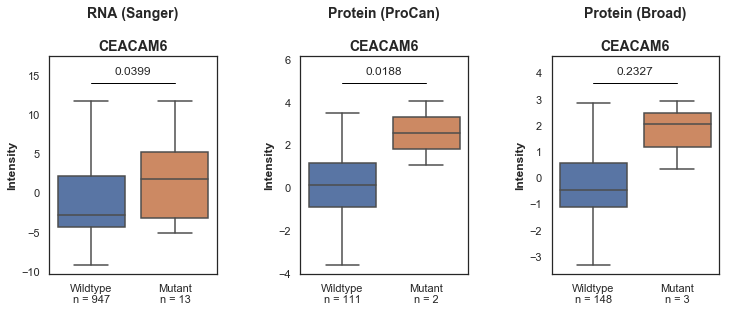

In [230]:
generate_mut_comparisons(protein_to_gene_dict['CEAM6_HUMAN'])

In [231]:
print('Proteins upregulated at RNA level: ',str(df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna > 1)].shape[0]))
print('Proteins upregulated at protein level: ',str(df_mut_stats[lambda x: (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot > 1)].shape[0]))

Proteins upregulated at RNA level:  18
Proteins upregulated at protein level:  12


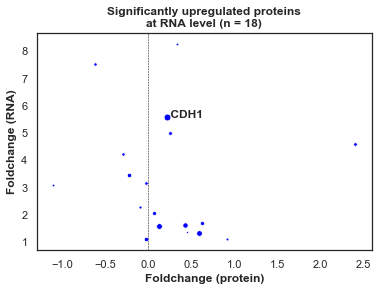

In [234]:
protein_list = df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna > 1)].index.tolist()
for protein in protein_list:
    plot = sns.scatterplot(x='foldchange_prot', y='foldchange_rna', data=df_mut_stats[lambda x: x.index == protein], color='blue', s=df_mut_stats.loc[protein,'mt_num_total'])
    if df_mut_stats.loc[protein,'foldchange_rna'] > 5 and df_mut_stats.loc[protein,'mt_num_total'] > 20:
        plot.text(df_mut_stats.loc[protein,'foldchange_prot'], df_mut_stats.loc[protein,'foldchange_rna'], ' '+protein_to_gene_dict[protein], weight='bold')
plot.axvline(x=0, linestyle='--', color='black', linewidth=0.5)
plot.set_xlabel('Foldchange (protein)', weight='bold')
plot.set_ylabel('Foldchange (RNA)', weight='bold')
plot.set_title('Significantly upregulated proteins\nat RNA level (n = '+str(len(protein_list))+')', weight='bold')
plt.show()

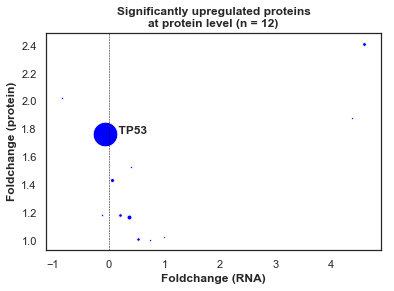

In [235]:
protein_list = df_mut_stats[lambda x: (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot > 1)].index.tolist()
for protein in protein_list:
    plot = sns.scatterplot(x='foldchange_rna', y='foldchange_prot', data=df_mut_stats[lambda x: x.index == protein], color='blue', s=df_mut_stats.loc[protein,'mt_num_total'])
plot.text(df_mut_stats.loc['P53_HUMAN','foldchange_rna'], df_mut_stats.loc['P53_HUMAN','foldchange_prot'], '    TP53', weight='bold')
plot.axvline(x=0, linestyle='--', color='black', linewidth=0.5)
plot.set_xlabel('Foldchange (RNA)', weight='bold')
plot.set_ylabel('Foldchange (protein)', weight='bold')
plot.set_title('Significantly upregulated proteins\nat protein level (n = '+str(len(protein_list))+')', weight='bold')
plt.show()

##### Cascade effects (downregulation)

In [236]:
print('Proteins downregulated at RNA and protein level: ',str(df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna < -1) & (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot < -1)].shape[0]))

Proteins downregulated at RNA and protein level:  0


In [237]:
print('Proteins downregulated at RNA level: ',str(df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna < -1)].shape[0]))
print('Proteins downregulated at protein level: ',str(df_mut_stats[lambda x: (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot < -1)].shape[0]))

Proteins downregulated at RNA level:  68
Proteins downregulated at protein level:  11


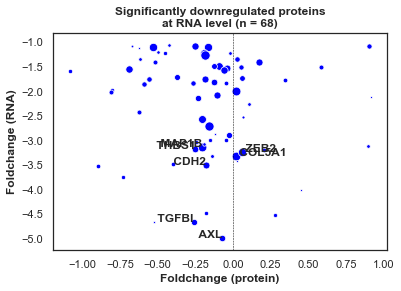

In [238]:
protein_list = df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna < -1)].index.tolist()
for protein in protein_list:
    plot = sns.scatterplot(x='foldchange_prot', y='foldchange_rna', data=df_mut_stats[lambda x: x.index == protein], color='blue', s=df_mut_stats.loc[protein,'mt_num_total'])
    if df_mut_stats.loc[protein,'mt_num_total'] > 25 and df_mut_stats.loc[protein,'foldchange_rna'] < -3:
        if df_mut_stats.loc[protein,'foldchange_prot'] < 0:
            ha_val = 'right'
        else:
                ha_val = 'left'
        plot.text(df_mut_stats.loc[protein,'foldchange_prot'], df_mut_stats.loc[protein,'foldchange_rna'], ' '+protein_to_gene_dict[protein], weight='bold', ha=ha_val)
plot.axvline(x=0, linestyle='--', color='black', linewidth=0.5)
plot.set_xlabel('Foldchange (protein)', weight='bold')
plot.set_ylabel('Foldchange (RNA)', weight='bold')
plot.set_title('Significantly downregulated proteins\nat RNA level (n = '+str(len(protein_list))+')', weight='bold')
plt.show()

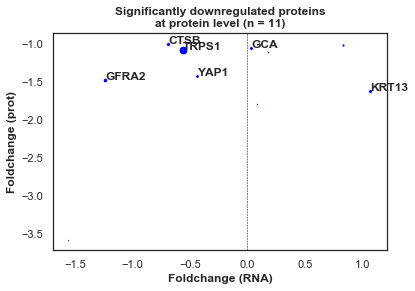

In [260]:
protein_list = df_mut_stats[lambda x: (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot < -1)].index.tolist()
for protein in protein_list:
    plot = sns.scatterplot(x='foldchange_rna', y='foldchange_prot', data=df_mut_stats[lambda x: x.index == protein], color='blue', s=df_mut_stats.loc[protein,'mt_num_total'])
    if df_mut_stats.loc[protein,'mt_num_total'] > 10:
        plot.text(df_mut_stats.loc[protein,'foldchange_rna'], df_mut_stats.loc[protein,'foldchange_prot'], protein_to_gene_dict[protein], weight='bold')
plot.axvline(x=0, linestyle='--', color='black', linewidth=0.5)
plot.set_xlabel('Foldchange (RNA)', weight='bold')
plot.set_ylabel('Foldchange (prot)', weight='bold')
plot.set_title('Significantly downregulated proteins\nat protein level (n = '+str(len(protein_list))+')', weight='bold')
plt.show()

##### Inconsistent directions

In [249]:
print('Proteins upregulated at RNA level and downregulated at protein level: ',str(df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna < -1) & (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot > 1)].shape[0]))

Proteins upregulated at RNA level and downregulated at protein level:  0


In [248]:
print('Proteins downregulated at RNA level and upregulated at protein level: ',str(df_mut_stats[lambda x: (x.pvalue_rna > 10**(0.05*-1)) & (x.foldchange_rna > 1) & (x.pvalue_prot > 10**(0.05*-1)) & (x.foldchange_prot < -1)].shape[0]))

Proteins downregulated at RNA level and upregulated at protein level:  0


##### Examine chi-square

In [243]:
curr_df = df_mut_stats[lambda x: (x.wt_num_missing > 10) | (x.mt_num_missing > 10)]
curr_df = curr_df[lambda x: x.missing_chi_pval > 0]
curr_df['chi_fc'] = np.log2(curr_df['chi_fc']) 

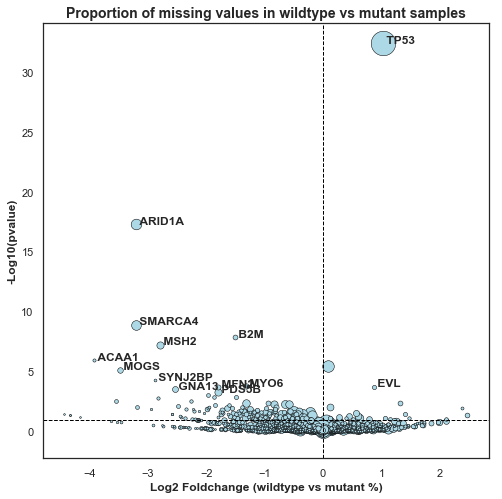

In [244]:
fig = plt.figure(figsize=[8,8])
for protein in curr_df.index.tolist():
    plot = sns.scatterplot(x='chi_fc', y='-log10_missing_chi_pval', data=curr_df[lambda x: x.index == protein], color='lightblue', edgecolor='black', linewidth=0.5, s=curr_df.loc[protein,'mt_num_total'])
for protein in curr_df[lambda x: (abs(x.chi_fc) > 0.2) & (x.missing_chi_pval < 0.001)].index.tolist():
    plot.text(curr_df.loc[protein,'chi_fc'], curr_df.loc[protein,'-log10_missing_chi_pval'], ' '+protein_to_gene_dict[protein], weight='bold')
plot.set_xlabel('Log2 Foldchange (wildtype vs mutant %)', weight='bold')
plot.set_ylabel('-Log10(pvalue)', weight='bold')
plot.axvline(x=0, linestyle='--', linewidth=1, color='black')
plot.axhline(y=10**(-1*0.05), linestyle='--', linewidth=1, color='black')
plot.set_title('Proportion of missing values in wildtype vs mutant samples', weight='bold', fontsize=14)
plt.show()

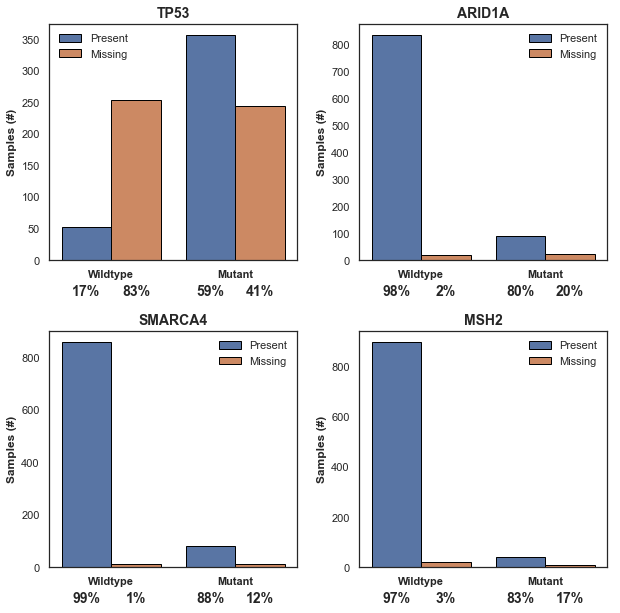

In [245]:
curr_df = df_mut_stats[['wt_num_val','wt_num_missing','mt_num_val','mt_num_missing']].unstack().to_frame('Sample_num').reset_index().rename(columns={'level_0':'sample_type','level_1':'Protein'})
curr_df.loc[curr_df[lambda x: x.sample_type.str.contains('wt')].index.tolist(),'Sample'] = 'Wildtype'
curr_df.loc[curr_df[lambda x: x.sample_type.str.contains('mt')].index.tolist(),'Sample'] = 'Mutant'
curr_df['sample_type'] = curr_df['sample_type'].str.replace('wt_num_val','Present')
curr_df['sample_type'] = curr_df['sample_type'].str.replace('mt_num_val','Present')
curr_df['sample_type'] = curr_df['sample_type'].str.replace('wt_num_missing','Missing')
curr_df['sample_type'] = curr_df['sample_type'].str.replace('mt_num_missing','Missing')
def generate_missing_val_num_plot(gene):
    protein = gene_to_protein_dict[gene]
    plot = sns.barplot(x='Sample', y='Sample_num', hue='sample_type', data=curr_df[lambda x: x.Protein == protein], edgecolor='black')
    plot.set_xlabel('')
    plot.set_ylabel('Samples (#)', weight='bold')
    plot.set_title(gene, weight='bold', fontsize=14)
    plot.legend(frameon=False)
    plot.set_xticklabels(plot.get_xticklabels(), weight='bold')
    plot.text(0.15, -0.15, format(curr_df.set_index('Protein')[lambda x: (x.sample_type == 'Present') & (x.Sample == 'Wildtype')].loc[protein,'Sample_num']/df_mut_stats.loc[protein,'wt_num_total']*100,'.0f')+'%', transform=ax.transAxes, ha='center', weight='bold', fontsize=14)
    plot.text(0.35, -0.15, format(curr_df.set_index('Protein')[lambda x: (x.sample_type == 'Missing') & (x.Sample == 'Wildtype')].loc[protein,'Sample_num']/df_mut_stats.loc[protein,'wt_num_total']*100,'.0f')+'%', transform=ax.transAxes, ha='center', weight='bold', fontsize=14)
    plot.text(0.65, -0.15, format(curr_df.set_index('Protein')[lambda x: (x.sample_type == 'Present') & (x.Sample == 'Mutant')].loc[protein,'Sample_num']/df_mut_stats.loc[protein,'mt_num_total']*100,'.0f')+'%', transform=ax.transAxes, ha='center', weight='bold', fontsize=14)
    plot.text(0.85, -0.15, format(curr_df.set_index('Protein')[lambda x: (x.sample_type == 'Missing') & (x.Sample == 'Mutant')].loc[protein,'Sample_num']/df_mut_stats.loc[protein,'mt_num_total']*100,'.0f')+'%', transform=ax.transAxes, ha='center', weight='bold', fontsize=14)
    return plot
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(2,2,1)
generate_missing_val_num_plot('TP53')
ax = fig.add_subplot(2,2,2)
generate_missing_val_num_plot('ARID1A')
ax = fig.add_subplot(2,2,3)
generate_missing_val_num_plot('SMARCA4')
ax = fig.add_subplot(2,2,4)
generate_missing_val_num_plot('MSH2')
plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()

##### Find out whether peptides are less commonly detected in samples with mutations in that peptide

In [2698]:
protein_list = df_mut_stats[lambda x: (abs(x.foldchange_prot) < 1) & (x.pvalue_prot > 10**(-0.05))].sort_values('mt_num_total', ascending=False).index.tolist()
protein_seq = {}
for record in SeqIO.parse("/Users/rpoulos/Documents/Data/zDB/uniprot_sprot.fasta", "fasta"):
    for protein in protein_list:
        if '|'+protein in record.id:
            protein_seq[protein] = str(record.seq)
print('Number of proteins examiend: ',len(protein_list))

Number of proteins examiend:  445


In [2496]:
protein_list_peptides = {}
peptide_loc_dict = {}
protein_aa_loc_dict = {}
protein_aa_loc_list_dict = {}
protein_peptide_mut_dict = {}
for protein in protein_list:
    protein_list_peptides[protein] = [x.split('=')[1] for x in df_pept_raw.columns.tolist() if x.startswith(protein)]
    peptide_loc_dict[protein] = {}
    for peptide in protein_list_peptides[protein]:
        if peptide in protein_seq[protein]:
            start_val = protein_seq[protein].find(peptide)+1
            end_val = start_val+len(peptide)
            peptide_loc_dict[protein][peptide] = [start_val, end_val]
    protein_aa_loc_dict[protein] = {}
    curr_aa = df_mut[lambda x: x.Gene == protein_to_gene_dict[protein]]['AA'].unique().tolist()
    curr_loc = []
    for aa in curr_aa:
        loc = ''
        switch = 0
        for n in aa.split('p.')[1]:
            if n.isdigit():
                loc+=n
            elif switch == 1:
                break
            else:
                switch = 1
        if loc != '':
            protein_aa_loc_dict[protein][aa] = loc
            curr_loc.append(loc)
    protein_aa_loc_list_dict[protein] = list(set(curr_loc))
    protein_peptide_mut_dict[protein] = {}
    for peptide in peptide_loc_dict[protein]:
        for val in protein_aa_loc_list_dict[protein]:
            if float(val) > peptide_loc_dict[protein][peptide][0] and float(val) < peptide_loc_dict[protein][peptide][1]:
                protein_peptide_mut_dict[protein][peptide] = []
                for mut in protein_aa_loc_dict[protein]:
                    if val == protein_aa_loc_dict[protein][mut]:
                        protein_peptide_mut_dict[protein][peptide].append(mut)

In [2670]:
df_mut_detect = pd.DataFrame()
num = 0
for protein in protein_list:
    for peptide in protein_peptide_mut_dict[protein]:
        num += 1
        df_mut_detect.loc[num,'Protein'] = protein
        df_mut_detect.loc[num,'Peptide'] = peptide
        mt_samples = df_mut[lambda x: (x.Gene == protein_to_gene_dict[protein]) & (x.AA.isin(protein_peptide_mut_dict[protein][peptide]))]['SAMPLE'].tolist()
        sample_num = len(mt_samples)
        mt_samples = df_sample_map[lambda x: x.Cell_line.isin(mt_samples)].index.tolist()
        if len(mt_samples) != 0:
            peptide_list = [x for x in df_pept_raw.columns.tolist() if x.startswith(protein+'=')]
            curr_peptide = [x for x in peptide_list if '='+peptide+'=' in x]
            df_mut_detect.loc[num,'Mean_val'] = df_pept_raw.loc[mt_samples, peptide_list].count().mean()/len(mt_samples)
            df_mut_detect.loc[num,'Actual_val'] = df_pept_raw.loc[mt_samples, curr_peptide].count()[0]/len(mt_samples)
            df_mut_detect.loc[num,'Mutated_samples'] = sample_num
df_mut_detect['Diff_val'] = df_mut_detect['Actual_val']/df_mut_detect['Mean_val']

In [2699]:
print('Number of peptides with decrease observations at mutant peptides: ', df_mut_detect[lambda x: x.Diff_val < 1].shape[0])
print('Number of peptides with increased observations at mutant peptides: ', df_mut_detect[lambda x: x.Diff_val > 1].shape[0])

Number of peptides with decrease observations at mutant peptides:  780
Number of peptides with increased observations at mutant peptides:  367


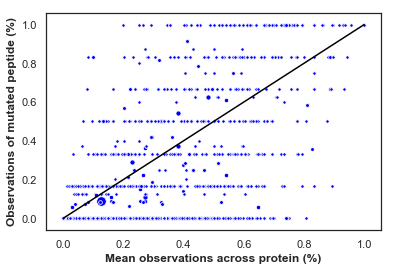

In [2682]:
for num in df_mut_detect.index.tolist():
    plot = sns.scatterplot(x='Mean_val', y='Actual_val', data=df_mut_detect[lambda x: x.index == num], color='blue', s=10+df_mut_detect.loc[num,'Mutated_samples']*df_mut_detect.loc[num,'Mutated_samples'])
plot.plot([0,1],[0,1], color='black')
plot.set_xlabel('Mean observations across protein (%)', weight='bold')
plot.set_ylabel('Observations of mutated peptide (%)', weight='bold')
plt.show()

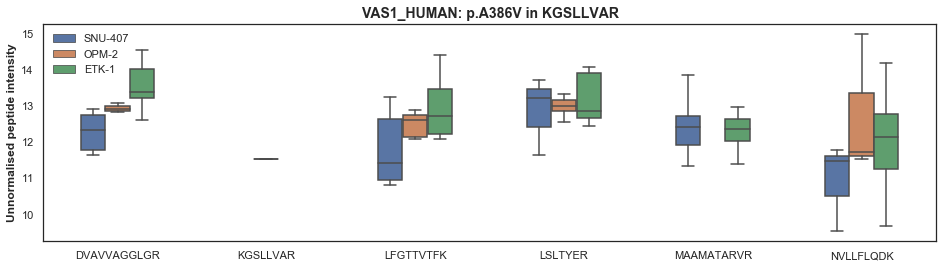

In [2696]:
protein = 'VAS1_HUMAN'
peptide = 'KGSLLVAR'
mutation = protein_peptide_mut_dict[protein][peptide][0]
mt_samples = df_mut[lambda x: (x.Gene == protein_to_gene_dict[protein]) & (x.AA == mutation)]['SAMPLE'].unique().tolist()
mt_samples = df_sample_map[lambda x: x.Cell_line.isin(mt_samples)].index.tolist()
curr_df = df_pept_raw[[x for x in df_pept_raw.columns.tolist() if x.startswith(protein)]].loc[mt_samples].unstack().to_frame('Peptide').reset_index()
curr_df['Cell_line'] = curr_df['index'].map(dict_sample_map['Cell_line'])
fig = plt.figure(figsize=[16,4])
plot = sns.boxplot(x='Identifier', y='Peptide', hue='Cell_line', data=curr_df, width=0.5)
plot.set_xlabel('')
plot.set_ylabel('Unnormalised peptide intensity', weight='bold')
plot.set_title(protein+': '+mutation+' in '+peptide, weight='bold', fontsize=14)
plot.legend(frameon=False)
plot.set_xticklabels([x.get_text().split('=')[1] for x in plot.get_xticklabels()], rotation=0)
plt.show()

### Integration of copy number and mutation

In [2727]:
df_pancan = pd.read_csv(source_folder+'PANCAN_mobem.csv.gz').set_index('COSMIC_ID')
df_pancan.index = df_pancan.index.astype(str)
df_pancan = df_pancan[lambda x: x.index.isin(df_cell_map['COSMIC_ID'].unique().tolist())]
df_pancan.index = df_pancan.index.map(df_cell_map.reset_index().set_index('COSMIC_ID').to_dict()['Cell_line'])

In [2963]:
def generate_mutation_intensity_plot(protein, mut_col, cna_col, cnv_type, dtaframe, dtatype, increase_val):
    mt_samples = df_pancan[lambda x: x[mut_col] == 1].index.tolist()
    cna_samples = df_pancan[lambda x: x[cna_col] == 1].index.tolist()
    wt_samples = [x for x in df_pancan.index.tolist() if x not in mt_samples and x not in cna_samples and x in dtaframe.index.tolist()]
    both_samples = [x for x in mt_samples if x in cna_samples and x in dtaframe.index.tolist()]
    mt_samples = [x for x in mt_samples if x not in both_samples and x in dtaframe.index.tolist()]
    cna_samples = [x for x in cna_samples if x not in both_samples and x in dtaframe.index.tolist()]
    curr_df = dtaframe[[protein]][lambda x: ~x.index.str.contains('Control_HEK293T')]
    curr_df.loc[wt_samples,'Mutation_status'] = 'Wildtype'
    curr_df.loc[mt_samples,'Mutation_status'] = 'Mutant'
    curr_df.loc[cna_samples,'Mutation_status'] = 'CNV '+cnv_type
    curr_df.loc[both_samples,'Mutation_status'] = 'Mutant & CNV '+cnv_type
    curr_df = curr_df.dropna()
    wt_samples = [x for x in wt_samples if x in curr_df.index.tolist()]
    both_samples = [x for x in both_samples if x in curr_df.index.tolist()]
    mt_samples = [x for x in mt_samples if x in curr_df.index.tolist()]
    cna_samples = [x for x in cna_samples if x in curr_df.index.tolist()]
    plot = sns.boxplot(x='Mutation_status', y=protein, data=curr_df, order=['Wildtype','Mutant','CNV '+cnv_type,'Mutant & CNV '+cnv_type], showfliers=False)
    plot = sns.swarmplot(x='Mutation_status', y=protein, data=curr_df, order=['Wildtype','Mutant','CNV '+cnv_type,'Mutant & CNV '+cnv_type], color='black', s=2) 
    plot.set_xticklabels([label.get_text()+'\n(n = '+str(len(curr_df[lambda x: x.Mutation_status == label.get_text()]))+')' for label in plot.get_xticklabels()])
    plot.set_xlabel('Mutation status', weight='bold')
    plot.set_ylabel('Protein intensity', weight='bold')
    plot.set_title(protein_to_gene_dict[protein]+' ('+dtatype+')', weight='bold', fontsize=14)
    pval_dict = {'pval_wt_mt':[0,1,0.6,len(wt_samples),len(mt_samples)],'pval_wt_cnv':[0,2,0.7,len(wt_samples),len(cna_samples)],'pval_wt_both':[0,3,0.8,len(wt_samples),len(both_samples)],'pval_mt_cnv':[1.05,1.95,0.6,len(mt_samples),len(cna_samples)],'pval_mt_both':[1,3,0.5,len(mt_samples),len(both_samples)],'pval_cnv_both':[2,3,0.6,len(cna_samples),len(both_samples)]}
    pval_dict['pval_wt_mt'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Wildtype'][protein], curr_df[lambda x: x.Mutation_status == 'Mutant'][protein])[1])
    pval_dict['pval_wt_cnv'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Wildtype'][protein], curr_df[lambda x: x.Mutation_status == 'CNV '+cnv_type][protein])[1])
    pval_dict['pval_wt_both'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Wildtype'][protein], curr_df[lambda x: x.Mutation_status == 'Mutant & CNV '+cnv_type][protein])[1])
    pval_dict['pval_mt_cnv'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Mutant'][protein], curr_df[lambda x: x.Mutation_status == 'CNV '+cnv_type][protein])[1])
    pval_dict['pval_mt_both'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Wildtype'][protein], curr_df[lambda x: x.Mutation_status == 'Mutant & CNV '+cnv_type][protein])[1])
    pval_dict['pval_cnv_both'].append(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'CNV '+cnv_type][protein], curr_df[lambda x: x.Mutation_status == 'Mutant & CNV '+cnv_type][protein])[1])
    y_pos = (plot.get_ylim()[1] - plot.get_ylim()[0])*increase_val + plot.get_ylim()[1]
    for pval_type in pval_dict:
        pval = pval_dict[pval_type][5]
        if pval < 0.05 and pval_dict[pval_type][3] > 1 and pval_dict[pval_type][4] > 1:
            plot.plot([pval_dict[pval_type][0],pval_dict[pval_type][1]],[pval_dict[pval_type][2]*y_pos,pval_dict[pval_type][2]*y_pos], color='black', linewidth=1.25)
            if pval < 0.0001:
                star_val = '****'
            elif pval < 0.001:
                star_val = '***'
            elif pval < 0.01:
                star_val = '**'
            else:
                star_val = '*'
            plot.text((pval_dict[pval_type][1]-pval_dict[pval_type][0])/2+pval_dict[pval_type][0], (pval_dict[pval_type][2]-0.05)*y_pos, star_val, ha='center', fontsize=14)
    plot.set_ylim(plot.get_ylim()[0], y_pos)
    return plot, curr_df

In [2991]:
# gene = 'MET'
# protein = gene_to_protein_dict[gene]
# curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
# num = 0
# for x in curr_list:
#     print(num, x)
#     num += 1

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


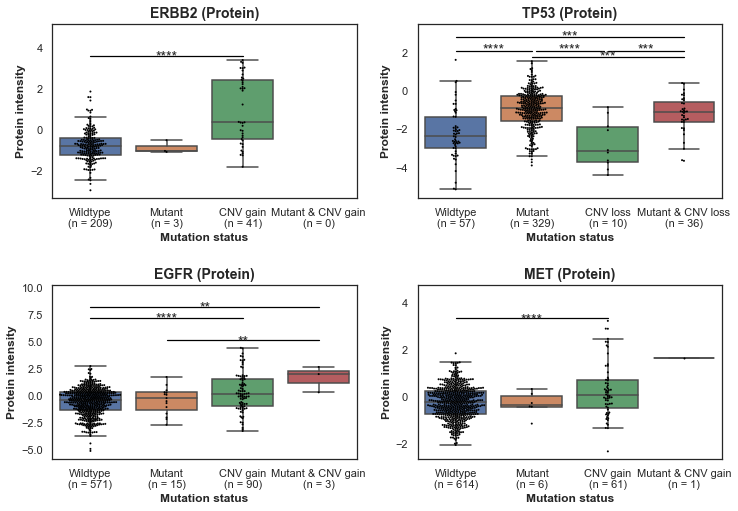

In [2988]:
fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2,2,1)
gene = 'ERBB2'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot, curr_df = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[2], 'gain', df_prot, 'Protein', 0.2)

ax = fig.add_subplot(2,2,2)
gene = 'TP53'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[2], 'loss', df_prot, 'Protein', 0.2)

ax = fig.add_subplot(2,2,3)
gene = 'EGFR'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[1], 'gain', df_prot, 'Protein', 0.5)

ax = fig.add_subplot(2,2,4)
gene = 'MET'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[1], 'gain', df_prot, 'Protein', 0.2)

plt.subplots_adjust(hspace=0.5)
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


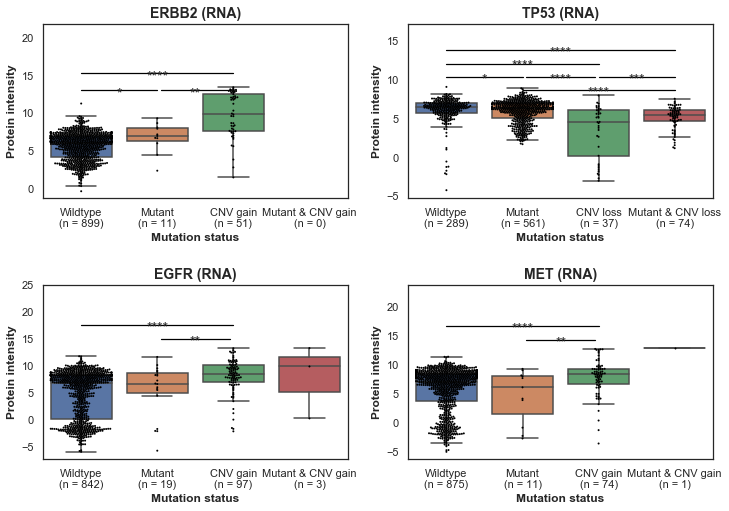

In [2990]:
fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2,2,1)
gene = 'ERBB2'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot, curr_df = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[2], 'gain', df_rna, 'RNA', 0.5)

ax = fig.add_subplot(2,2,2)
gene = 'TP53'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[2], 'loss', df_rna, 'RNA', 0.5)

ax = fig.add_subplot(2,2,3)
gene = 'EGFR'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[1], 'gain', df_rna, 'RNA', 0.5)

ax = fig.add_subplot(2,2,4)
gene = 'MET'
protein = gene_to_protein_dict[gene]
curr_list = [x for x in df_pancan.columns.tolist() if protein_to_gene_dict[protein] in x]
plot = generate_mutation_intensity_plot(protein, curr_list[0], curr_list[1], 'gain', df_rna, 'RNA', 0.5)

plt.subplots_adjust(hspace=0.5)
plt.show()

### Methylation analysis

In [3054]:
df_meth = pd.read_csv(source_folder+'methy_beta_gene_promoter.csv.gz').rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')
df_meth.index = df_meth.index.map(gene_to_protein_dict)
df_meth = df_meth[lambda x: x.index.isin(df_prot.columns.tolist())]
df_meth = df_meth[lambda x: x.index.isin([x for x in df_meth.index.tolist() if df_meth.index.tolist().count(x) == 1])]
df_meth = df_meth.rename(columns=df_cell_map.reset_index().set_index('SIDM').to_dict()['Cell_line'])
df_meth = df_meth[[x for x in df_meth.columns.tolist() if 'SIDM' not in x]].transpose()

In [3088]:
df_cnv_prot = df_cnv.rename(columns=gene_to_protein_dict)
df_cnv_prot = df_cnv_prot[[x for x in df_cnv_prot.columns.tolist() if x in df_prot.columns.tolist() and df_cnv_prot.columns.tolist().count(x) == 1]]

In [3167]:
def make_correlation_matrix(dtaframe_a, dtaframe_b, label_a, label_b):
    df_corr = pd.DataFrame()
    for protein in [x for x in dtaframe_a.columns.tolist() if x in dtaframe_b.columns.tolist()]:
        curr_df = dtaframe_a[[protein]].rename(columns={protein:label_a}).join(dtaframe_b[[protein]].rename(columns={protein:label_b})).dropna()
        curr_df = curr_df.join(df_cell_map['Tissue_type'])[lambda x: ~x.Tissue_type.str.contains('Haematopoietic')].drop('Tissue_type', axis=1)
        if len(curr_df) > 2:
            df_corr.loc[protein,'Correlation'] = scipy.stats.pearsonr(curr_df[label_a], curr_df[label_b])[0]
    plot = sns.distplot(df_corr['Correlation'], color='blue')
    plot.axvline(x=0, color='black', linestyle='--', linewidth=2)
    plot.text(0.05,0.9,'Median r = '+format(df_corr['Correlation'].median(),'.2f'), weight='bold', transform=ax.transAxes, fontsize=14)
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title(label_a+' ~ '+label_b+'\ncorrelation (n = '+str(len(df_corr))+' proteins)', weight='bold', fontsize=14)
    return df_corr, plot

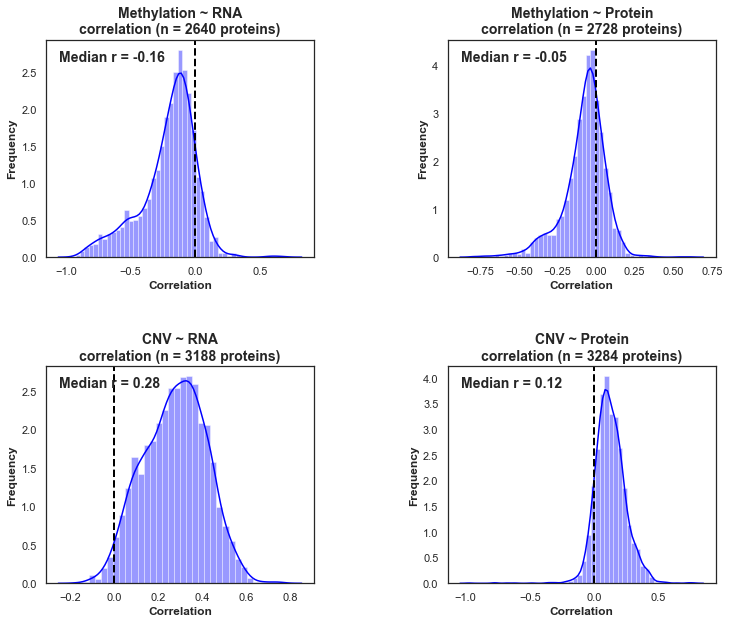

In [3168]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(2,2,1)
df_corr_meth_rna, plot = make_correlation_matrix(df_meth, df_rna, 'Methylation', 'RNA')
ax = fig.add_subplot(2,2,2)
df_corr_meth_prot, plot = make_correlation_matrix(df_meth, df_prot, 'Methylation', 'Protein')
ax = fig.add_subplot(2,2,3)
df_corr_cnv_rna, plot = make_correlation_matrix(df_cnv_prot, df_rna, 'CNV', 'RNA')
ax = fig.add_subplot(2,2,4)
df_corr_cnv_prot, plot = make_correlation_matrix(df_cnv_prot, df_prot, 'CNV', 'Protein')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

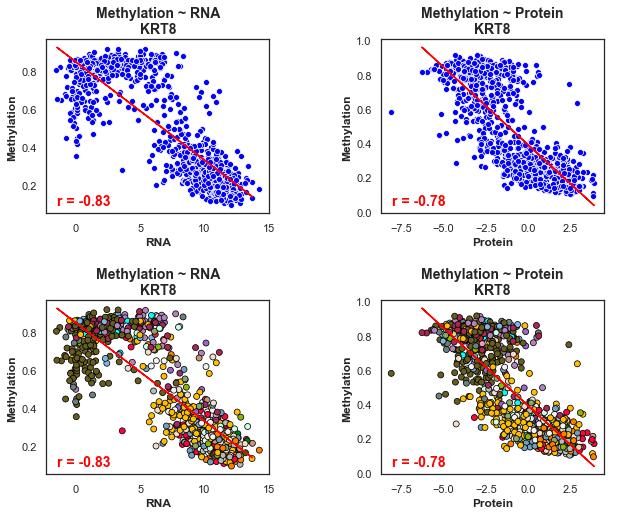

In [3161]:
def make_omic_corr_plots(protein, dtaframe_a, dtaframe_b, label_a, label_b, corr_dtaframe, colour):
    curr_df = dtaframe_a[[protein]].rename(columns={protein:label_a}).join(dtaframe_b[[protein]].rename(columns={protein:label_b})).dropna().join(df_cell_map['Tissue_type'])
    if colour == 'blue':
        plot = sns.scatterplot(x=label_b, y=label_a, data=curr_df, color='blue')
    else:
        plot = sns.scatterplot(x=label_b, y=label_a, data=curr_df, hue='Tissue_type', palette=tissue_colours, edgecolor='black')
        plot.legend_.remove()
    plot.set_title(label_a+' ~ '+label_b+'\n'+protein_to_gene_dict[protein], weight='bold', fontsize=14)
    plot.set_xlabel(label_b, weight='bold')
    plot.set_ylabel(label_a, weight='bold')
    X = curr_df[label_b].values.reshape(-1,1)
    y = curr_df[label_a].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    plot.plot(X_test, y_pred, color='red')
    plot.text(0.05, 0.05, 'r = '+format(corr_dtaframe.loc[protein,'Correlation'],'.2f'), color='red', weight='bold', transform=ax.transAxes, fontsize=14)
    return plot
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(2,2,1)
plot = make_omic_corr_plots('K2C8_HUMAN', df_meth, df_rna, 'Methylation', 'RNA', df_corr_meth_rna, 'blue')
ax = fig.add_subplot(2,2,2)
plot = make_omic_corr_plots('K2C8_HUMAN', df_meth, df_prot, 'Methylation', 'Protein', df_corr_meth_prot, 'blue')
ax = fig.add_subplot(2,2,3)
plot = make_omic_corr_plots('K2C8_HUMAN', df_meth, df_rna, 'Methylation', 'RNA', df_corr_meth_rna, None)
ax = fig.add_subplot(2,2,4)
plot = make_omic_corr_plots('K2C8_HUMAN', df_meth, df_prot, 'Methylation', 'Protein', df_corr_meth_prot, None)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

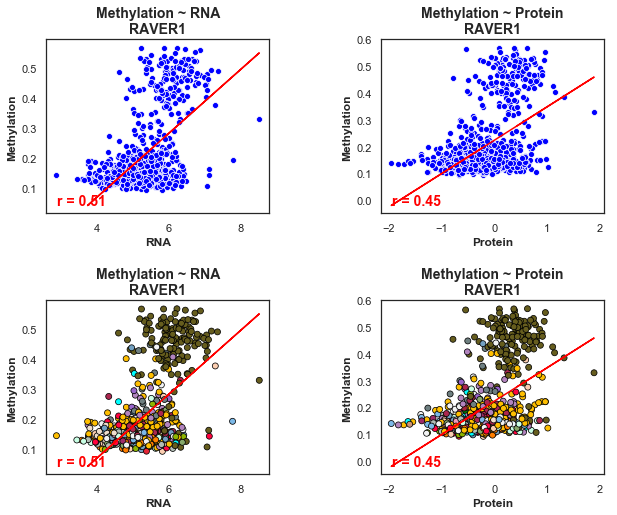

In [3164]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(2,2,1)
plot = make_omic_corr_plots('RAVR1_HUMAN', df_meth, df_rna, 'Methylation', 'RNA', df_corr_meth_rna, 'blue')
ax = fig.add_subplot(2,2,2)
plot = make_omic_corr_plots('RAVR1_HUMAN', df_meth, df_prot, 'Methylation', 'Protein', df_corr_meth_prot, 'blue')
ax = fig.add_subplot(2,2,3)
plot = make_omic_corr_plots('RAVR1_HUMAN', df_meth, df_rna, 'Methylation', 'RNA', df_corr_meth_rna, None)
ax = fig.add_subplot(2,2,4)
plot = make_omic_corr_plots('RAVR1_HUMAN', df_meth, df_prot, 'Methylation', 'Protein', df_corr_meth_prot, None)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [3140]:
df_corr_meth = df_corr_meth_rna.rename(columns={'Correlation':'RNA'}).join(df_corr_meth_prot.rename(columns={'Correlation':'Protein'}))

In [3163]:
df_corr_meth[lambda x: (x.Protein > 0) & (x.RNA > 0)].sort_values('Protein', ascending=False)

RNA   Protein
RAVR1_HUMAN  0.511367  0.454587
UTRO_HUMAN   0.583905  0.391778
LUC7L_HUMAN  0.244362  0.331560
RUXE_HUMAN   0.264561  0.322512
DPOD3_HUMAN  0.101101  0.313148
...               ...       ...
RFA3_HUMAN   0.044647  0.005405
UTP20_HUMAN  0.017274  0.004600
UBE2N_HUMAN  0.025445  0.003768
GAPR1_HUMAN  0.217397  0.002243
WBP2_HUMAN   0.021509  0.001679

[183 rows x 2 columns]

### Haematopoietic cell lines

###### Lineage differences

In [2144]:
blood_lineage_dict = {
    "B-Cell Non-Hodgkin's Lymphoma":'B-cell',
    'Plasma Cell Myeloma':'B-cell (myeloma)',
    'Acute Myeloid Leukemia':'Myeloid',
    'T-Lymphoblastic Leukemia':'T-cell',
    "Burkitt's Lymphoma":'B-cell',
    'B-Lymphoblastic Leukemia':'B-cell',
    'Chronic Myelogenous Leukemia':'Myeloid',
    'Non-Cancerous':'B-cell',
    "Hodgkin's Lymphoma":'B-cell',
    "T-Cell Non-Hodgkin's Lymphoma":'T-cell',
    'Other Blood Carcinomas':'Other'}

blood_cell_dict = {}
for cell_line in df_cell_map[lambda x: x.Tissue_type == 'Haematopoietic and Lymphoid'].index.tolist():
    if df_cell_map.loc[cell_line,'cancer_type_detail'] != 'Natural Killer Cell Lymphoblastic Leukemia Lymphoma':
        blood_cell_dict[cell_line] = blood_lineage_dict[df_cell_map.loc[cell_line,'Cancer_type']]
    else:
        blood_cell_dict[cell_line] = 'T-cell'
        
blood_colours = {
    'B-cell':'red',
    'B-cell (myeloma)': 'pink',
    'T-cell':'blue',
    'Myeloid':'green',
    'Other':'grey'
}
        
blood_cell_colours = {}
for cell_line in blood_cell_dict:
    blood_cell_colours[cell_line] = blood_colours[blood_cell_dict[cell_line]]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 171 samples in 0.000s...
[t-SNE] Computed neighbors for 171 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 171 / 171
[t-SNE] Mean sigma: 34.403781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.785103
[t-SNE] KL divergence after 1000 iterations: 0.450181


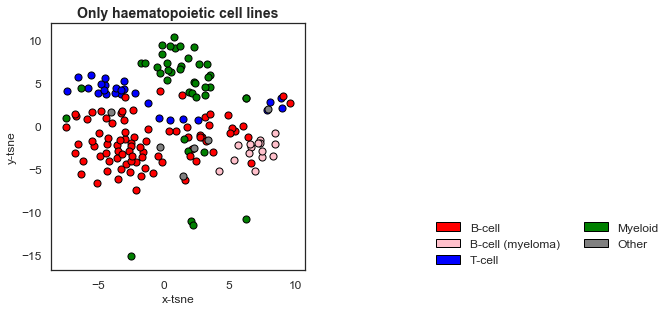

In [2140]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: (x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)
make_tsne('Cell_line', curr_df, blood_cell_colours, perplexity, random_seed, number_of_iterations, 'Only haematopoietic cell lines', blood_colours)

##### Investigate CD antigens

In [2074]:
cd_antigens = {   
    'CD1A_HUMAN':'CD1A',
    'CD3D_HUMAN':'CD3D',
    'CD3E_HUMAN':'CD3E',
    'CD3G_HUMAN':'CD3G',
    'CD3Z_HUMAN':'CD247',
    'CD19_HUMAN':'CD19',
    'CD20_HUMAN':'MS4A1',
    'SDC1_HUMAN':'SDC1',
    'CD33_HUMAN':'CD33',
    'CD34_HUMAN':'CD34',
    'FUT4_HUMAN':'FUT4',
    'NEP_HUMAN':'MME',
    'KIT_HUMAN':'KIT',
    'TNR8_HUMAN':'TNFRSF8',
    'ITAM_HUMAN':'ITGAM',
    'PTPRC_HUMAN':'PTPRC'}
cd_antigens = [x for x in list(cd_antigens.keys()) if x in df_prot.columns.tolist()]
print('Number of antigens found:',len(cd_antigens))

Number of antigens found: 3


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 171 samples in 0.000s...
[t-SNE] Computed neighbors for 171 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 171 / 171
[t-SNE] Mean sigma: 0.819997
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.604607
[t-SNE] KL divergence after 1000 iterations: 0.115045


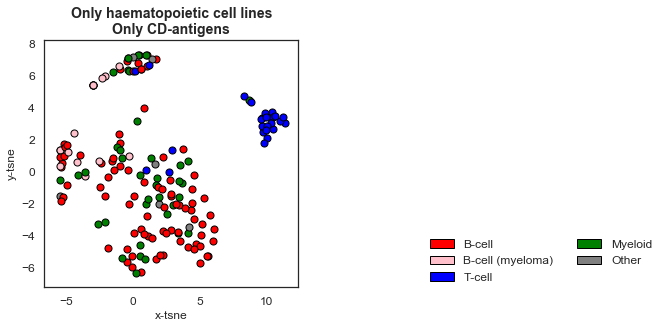

In [2107]:
curr_df = df_prot.join(df_cell_map['Tissue_type'])[lambda x: (x.Tissue_type.str.contains('Haematopoietic'))].drop('Tissue_type', axis=1)[cd_antigens]
make_tsne('Cell_line', curr_df, blood_cell_colours, perplexity, random_seed, number_of_iterations, 'Only haematopoietic cell lines\nOnly CD-antigens', blood_colours)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


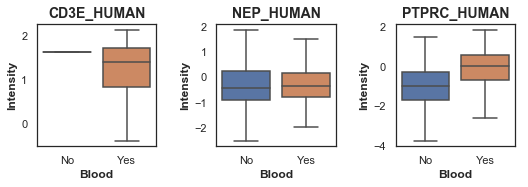

In [2076]:
curr_df = df_prot[cd_antigens]
curr_df.loc[df_cell_map[lambda x: x.Tissue_type.str.contains('Haematopo')].index.tolist(),'Blood'] = 'Yes'
curr_df.loc[df_cell_map[lambda x: ~x.Tissue_type.str.contains('Haematopo')].index.tolist(),'Blood'] = 'No'
num = 0
fig = plt.figure(figsize=[15,9])
for antigen in cd_antigens:
    num += 1
    ax = fig.add_subplot(3,5,num)
    plot = sns.boxplot(y=antigen, x='Blood', data=curr_df, showfliers=False)
    plot.set_xlabel('Blood', weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(antigen, fontsize=14, weight='bold')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

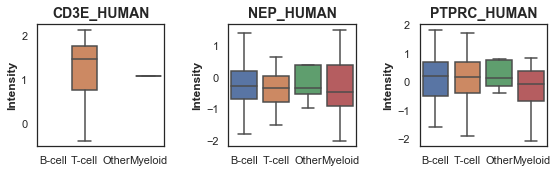

In [2077]:
curr_df = df_prot[cd_antigens].join(df_cell_map[['Tissue_type','Cancer_type']])[lambda x: x.Tissue_type == 'Haematopoietic and Lymphoid'].drop('Tissue_type', axis=1)
curr_df.loc[[x for x in blood_cell_dict if blood_cell_dict[x] == 'B-cell'],'Lineage'] = 'B-cell'
curr_df.loc[[x for x in blood_cell_dict if blood_cell_dict[x] == 'T-cell'],'Lineage'] = 'T-cell'
curr_df.loc[[x for x in blood_cell_dict if blood_cell_dict[x] == 'Myeloid'],'Lineage'] = 'Myeloid'
curr_df.loc[[x for x in blood_cell_dict if blood_cell_dict[x] == 'Other'],'Lineage'] = 'Other'
num = 0
fig = plt.figure(figsize=[16,9])
for antigen in cd_antigens:
    num += 1
    ax = fig.add_subplot(3,5,num)
    plot = sns.boxplot(y=antigen, x='Lineage', data=curr_df, showfliers=False)
    plot.set_xlabel('', weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(antigen, fontsize=14, weight='bold')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

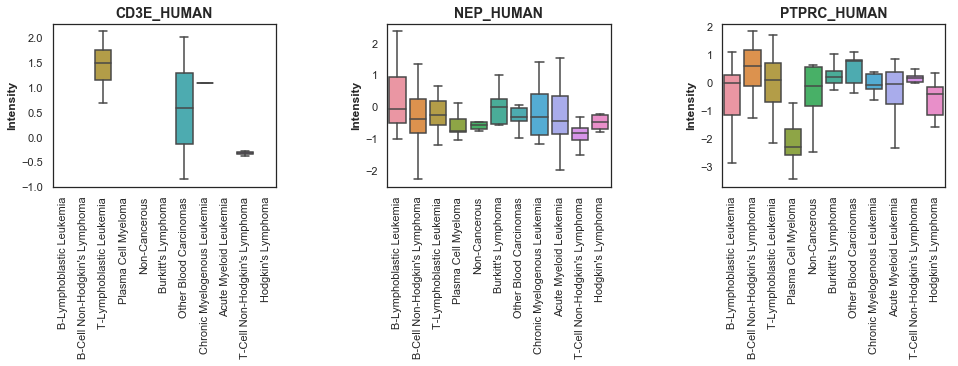

In [2079]:
curr_df = df_prot[cd_antigens].join(df_cell_map[['Tissue_type','Cancer_type']])[lambda x: x.Tissue_type == 'Haematopoietic and Lymphoid'].drop('Tissue_type', axis=1)
num = 0
fig = plt.figure(figsize=[16,3])
for antigen in cd_antigens:
    num += 1
    ax = fig.add_subplot(1,3,num)
    plot = sns.boxplot(y=antigen, x='Cancer_type', data=curr_df, showfliers=False)
    plot.set_xlabel('', weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.set_title(antigen, fontsize=14, weight='bold')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

##### Investigate fusions

In [2161]:
df_fusion = pd.read_csv(source_folder+'CCLE_Fusions_20181130.txt', sep='\t')
depmap_id_dict = pd.read_csv(source_folder+'CCLE_Cell_lines_annotations_20181226.txt', sep='\t').set_index('depMapID').to_dict()['CCLE_ID']
df_fusion['CCLE_ID'] = df_fusion['BroadID'].map(depmap_id_dict)
broad_id_dict = df_cell_map[lambda x: x.Tissue_type.str.contains('Haematopoietic')].reset_index().set_index('CCLE_ID').to_dict()['Cell_line']
df_fusion['Cell_line'] = df_fusion['CCLE_ID'].map(broad_id_dict)
df_fusion = df_fusjuion[lambda x: ~x.Cell_line.isna()]

In [2227]:
df_fusion_haem = df_fusion[lambda x: x.Cell_line.isin(df_cell_map[lambda x: x.Tissue_type.str.contains('Haematopoietic')].index.tolist())].set_index('Cell_line')
df_fusion_haem_count = df_fusion_haem[['X.sample','X.FusionName']].drop_duplicates().groupby('X.FusionName').size().to_frame('Freq').sort_values('Freq', ascending=False)
threshold = 3
common_fusions = df_fusion_haem_count[lambda x: x.Freq > threshold].index.tolist()
print('Number of common fusions (> '+str(threshold)+' cell lines) in haematopoietic tissue:',len(common_fusions))
common_fusions_dict = {}
for fusion in common_fusions:
    gene_a = fusion.split('-')[0].replace('@','')
    gene_b = fusion.split('-')[2].replace('@','')
    common_fusions_dict[fusion] = []
    if gene_a in gene_to_protein_dict:
        protein = gene_to_protein_dict[gene_a]
        if protein in df_prot.columns.tolist():
            common_fusions_dict[fusion].append(protein)
    if gene_b in gene_to_protein_dict:
        protein = gene_to_protein_dict[gene_b]
        if protein in df_prot.columns.tolist():
            common_fusions_dict[fusion].append(protein)
    if common_fusions_dict[fusion] == []:
        common_fusions_dict.pop(fusion)
print('Number of fusions with protein data:',len(common_fusions_dict))

Number of common fusions (> 3 cell lines) in haematopoietic tissue: 13
Number of fusions with protein data: 7


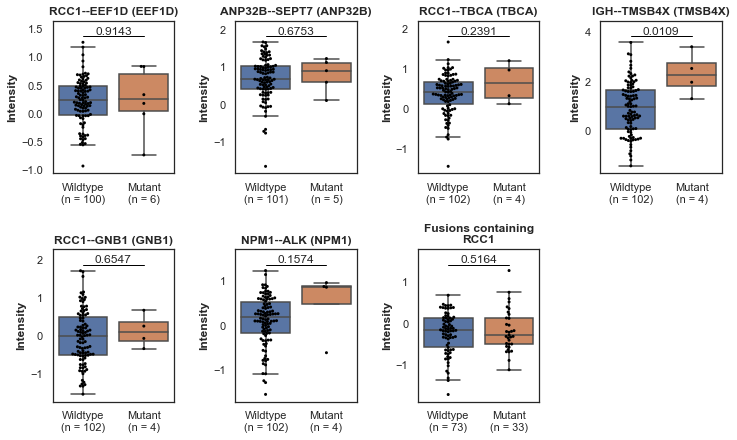

In [2285]:
def make_fusion_boxplots(protein, num):
    if protein != 'RCC1_HUMAN':
        mt_samples = df_fusion_haem[lambda x: x['X.FusionName'] == fusion].index.unique().tolist()
    else:
        mt_samples = df_fusion_haem[lambda x: x['X.FusionName'].str.contains('RCC1')].index.unique().tolist()
    wt_samples = [x for x in df_fusion_haem.index.unique().tolist() if x not in mt_samples]
    curr_df = df_prot[[protein]].loc[mt_samples+wt_samples]
    curr_df.loc[wt_samples,'Mutation_status'] = 'Wildtype'
    curr_df.loc[mt_samples,'Mutation_status'] = 'Mutant'
    curr_df = curr_df.sort_values('Mutation_status', ascending=False).dropna()
    ax = fig.add_subplot(2,4,num)
    plot = sns.boxplot(x='Mutation_status', y=protein, data=curr_df, showfliers=False)
    plot = sns.swarmplot(x='Mutation_status', y=protein, data=curr_df, color='black', s=3)
    plot.plot([0.25,0.75],[0.9,0.9], color='black', linewidth=1, transform=ax.transAxes)
    plot.text(0.5, 0.91, format(scipy.stats.ttest_ind(curr_df[lambda x: x.Mutation_status == 'Wildtype'][protein], curr_df[lambda x: x.Mutation_status == 'Mutant'][protein])[1],'.4f'), transform=ax.transAxes, ha='center')
    plot.set_ylim(plot.get_ylim()[0], plot.get_ylim()[1]+(plot.get_ylim()[1]-plot.get_ylim()[0])*0.1)
    if protein != 'RCC1_HUMAN':
        plot.set_title(fusion.replace('@','')+' ('+protein_to_gene_dict[protein]+')', weight='bold', fontsize=12)
    else:
        plot.set_title('Fusions containing\nRCC1', weight='bold')
    plot.set_xlabel('')
    plot.set_ylabel('Intensity', weight='bold')
    xticklabels = ['Wildtype\n(n = '+str(len(wt_samples))+')','Mutant\n(n = '+str(len(mt_samples))+')']
    plot.set_xticklabels(xticklabels)
    return plot

num = 0
fig = plt.figure(figsize=[12,7])
for fusion in common_fusions_dict:
    for protein in common_fusions_dict[fusion]:
        if protein != 'RCC1_HUMAN':
            num += 1
            make_fusion_boxplots(protein, num)
make_fusion_boxplots('RCC1_HUMAN', 7)            
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

### Investigating fusions across the cohort

In [63]:
df_fusion = pd.read_excel(source_folder+'SuppData2_Sanger_Fusions.xlsx')

In [90]:
df_fusion_count = df_fusion.groupby('Fusion Name').size().to_frame('Count').sort_values('Count', ascending=False)
common_fusions = df_fusion_count[lambda x: x.Count > 5].index.tolist()
print('Number of common fusions:',len(common_fusions))
fusion_genes = []
for fusion in common_fusions:
    fusion_genes.append(fusion.split('--')[0])
    fusion_genes.append(fusion.split('--')[1])
fusion_genes = list(set(fusion_genes))
print('Number of common fusion genes:',len(fusion_genes))
fusion_proteins = {}
for gene in fusion_genes:
    if gene in gene_to_protein_dict and gene_to_protein_dict[gene] in df_prot.columns.tolist():
        fusion_proteins[gene] = gene_to_protein_dict[gene]
print('Number of common fusion proteins:',len(fusion_proteins))

Number of common fusions: 69
Number of common fusion genes: 119
Number of common fusion proteins: 25


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


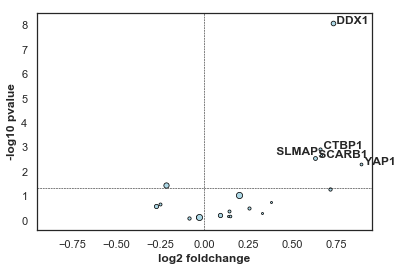

In [133]:
samples_analysed = [x for x in df_fusion['Cell Line'].unique().tolist() if x in df_cell_map.index.tolist()]
df_fusion_volc = pd.DataFrame()
for gene in fusion_proteins:
    protein = fusion_proteins[gene]
    mt_samples = [x for x in df_fusion[lambda x: x['Fusion Name'].str.contains(gene)]['Cell Line'].unique().tolist() if x in df_cell_map.index.tolist()]
    wt_samples = [x for x in samples_analysed if x not in mt_samples]
    wt_array = df_prot.loc[wt_samples,protein].dropna()
    mt_array = df_prot.loc[mt_samples,protein].dropna()
    df_fusion_volc.loc[protein,'pval'] = scipy.stats.ttest_ind(wt_array, mt_array)[1]
    df_fusion_volc.loc[protein,'foldchange'] = mt_array.mean() - wt_array.mean()
    df_fusion_volc.loc[protein,'mt_count'] = len(mt_samples)
df_fusion_volc['log10_pval'] = np.log10(df_fusion_volc['pval'])*-1
for protein in df_fusion_volc.index.tolist():
    plot = sns.scatterplot(x='foldchange', y='log10_pval', data=df_fusion_volc[lambda x: x.index == protein], color='lightblue', s=int(df_fusion_volc.loc[protein,'mt_count'])^2, edgecolor='black')
plot.set_xlabel('log2 foldchange', weight='bold')
plot.set_ylabel('-log10 pvalue', weight='bold')
plot.axvline(x=0, linestyle='--', color='black', linewidth=0.5)
plot.axhline(y=np.log10(0.05)*-1, linestyle='--', color='black', linewidth=0.5)
xlim_val = plot.get_xlim()
abs_xlim_val = []
for x in xlim_val:
    abs_xlim_val.append(abs(x))
plot.set_xlim(sorted(abs_xlim_val)[1]*-1, sorted(abs_xlim_val)[1])
for protein in df_fusion_volc[lambda x: (x.log10_pval > np.log10(0.05)*-1) & (abs(x.foldchange) > 0.5)].index.tolist():
    if protein == 'SLMAP_HUMAN':
        pos = 'right'
    else:
        pos = 'left'
    plot.text(df_fusion_volc.loc[protein,'foldchange'],df_fusion_volc.loc[protein,'log10_pval'], ' '+protein_to_gene_dict[protein]+' ', weight='bold', ha=pos)
plt.show()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


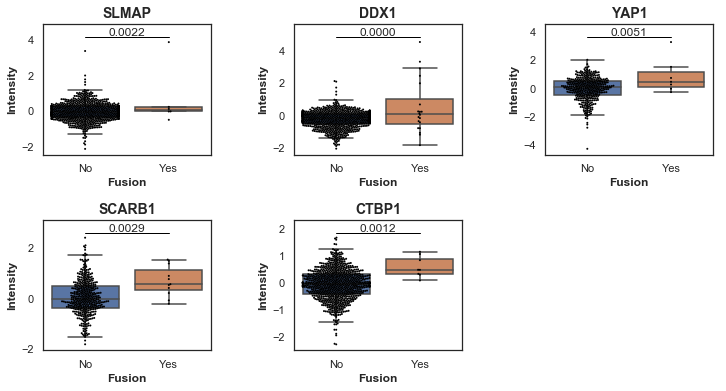

In [149]:
fig = plt.figure(figsize=[12,6])
num = 0
for protein in df_fusion_volc[lambda x: (x.log10_pval > np.log10(0.05)*-1) & (abs(x.foldchange) > 0.5)].index.tolist():
    gene = protein_to_gene_dict[protein]
    num += 1
    ax = fig.add_subplot(2,3,num)
    mt_samples = [x for x in df_fusion[lambda x: x['Fusion Name'].str.contains(gene)]['Cell Line'].unique().tolist() if x in df_cell_map.index.tolist()]
    wt_samples = [x for x in samples_analysed if x not in mt_samples]
    curr_df = df_prot[[protein]]
    curr_df.loc[mt_samples,'Fusion'] = 'Yes'
    curr_df.loc[wt_samples,'Fusion'] = 'No'
    curr_df = curr_df.sort_values('Fusion').dropna()
    plot = sns.boxplot(x='Fusion',y=protein, data=curr_df, showfliers=False)
    plot = sns.swarmplot(x='Fusion',y=protein, data=curr_df, s=2, color='black')
    plot.set_title(protein_to_gene_dict[protein], weight='bold', fontsize=14)
    plot.set_xlabel('Fusion', weight='bold')
    plot.set_ylabel('Intensity', weight='bold')
    plot.plot([0.25,0.75],[0.9,0.9], color='black', linewidth=1, transform=ax.transAxes)
    plot.text(0.5, 0.91, format(scipy.stats.ttest_ind(curr_df[lambda x: x.Fusion == 'Yes'][protein], curr_df[lambda x: x.Fusion == 'No'][protein])[1],'.4f'), transform=ax.transAxes, ha='center')
    plot.set_ylim(plot.get_ylim()[0], plot.get_ylim()[1]+(plot.get_ylim()[1]-plot.get_ylim()[0])*0.1)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()